In [1]:
import pdb
import torch, os
import argparse, datetime
import gc,time
from tqdm import tqdm
import __init__



#from src.gp_cpab.src.transformation.gp_cpab import gp_cpab
#from src.gp_cpab.src.transformation.gp_cpab_tmp import gp_cpab
from src.gp_cpab.src.transformation.configManager import configManager
from src.gp_cpab.src.extra.experiment_utilities import *

from src.models.trainer_tmp import vae_trainer
from src.unsuper.unsuper.data.mnist_data_loader import mnist_data_loader
from src.unsuper.unsuper.data.perception_data_loader import perception_data_loader
from src.unsuper.unsuper.helper.utility import model_summary
from src.models.encoder_decoder import get_encoder, get_decoder, get_list_encoders, get_list_decoders
from src.models import get_model

from src.seqsDataLoader import seqsReader, seqsDatasetLoader, Sequence_Data_Loader
from src.dataLoaderDiffeo import *

from src.models.experimental.vitae_ci_gp_detached_deepseq import vitae_ci_gp_no_deepseq
from src.models.experimental.deepsequence import DeepSequence

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Could not import libcpab, error was
No module named 'libcpab'


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [2]:
import argparse; import sys; sys.argv=['']; del sys

def argparser():
    """ Argument parser for the main script """
    parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
    # Model settings
    ms = parser.add_argument_group('Model settings')
    ms.add_argument('--model', type=str, default='vitae_ci', help='model to train')
    ms.add_argument('--ed_type', type=str, default='mlp,mlp', help='encoder/decoder type')
    ms.add_argument('--stn_type', type=str, default='gp_cpab', help='transformation type to use')
    ms.add_argument('--beta', type=float, default=16, help='beta value for beta-vae model') #16
    
    # Training settings
    ts = parser.add_argument_group('Training settings')
    ts.add_argument('--n_epochs', type=int, default=500, help='number of epochs of training')
    ts.add_argument('--eval_epoch', type=int, default=5, help='when to evaluate log(p(x))')
    ts.add_argument('--batch_size', type=int, default=10, help='size of the batches') # batch=10,warmup=10, epochs=100
    ts.add_argument('--warmup', type=int, default=5, help='number of warmup epochs for kl-terms')
    ts.add_argument('--lr', type=float, default=1e-3, help='learning rate for adam optimizer') # 1e-5 for 2 sequence deepseq 2 seqs other# 1e-3, 1e-7 # weird case for 550 iters and 1e-4, works in trans but regular in reconstruction
    
    # Paths to use
    paths = parser.add_argument_group('Paths')
    paths.add_argument('--path_orig', type=str, default="../data/WW5seqs.fasta", help='original sequence to deform')    #orig_3aa.fasta orig_3aag.fasta
    paths.add_argument('--path_aligned_orig', type=str, default="../data/WW5seqsMSA.fasta", help='original sequence to deform')    #orig_3aa.fasta orig_3aag.fasta
 
    paths.add_argument('--path_preexist_linear', type=str, default="../../models/CPABlinear3.pth", help='prebuilt model using linear case') 
    paths.add_argument('--path_preexist_gp', type=str, default="../../models/CPABGPB3.pth", help='prebuilt model using gp case')
    paths.add_argument('--path_automated_report', type=str, default="../../Results", help='path to save automatic report') 
    paths.add_argument('--logdir', type=str, default="../../Results", help='where to store results')

    gpsetup = parser.add_argument_group('GPSetup')
    #gpsetup.add_argument('--Task', type=int, default = 8, help='Amount of channels in multitask-gp estimator')
    #gpsetup.add_argument('--Initialization', type=list, default = [0.0, 0.143, 0.143, 0.143, 0.143, 0.143, 0.143, 0.143], help='multitaks-gp initialization') 
    gpsetup.add_argument('--Task', type=int, default = 19, help='Amount of channels in multitask-gp estimator')
    gpsetup.add_argument('--Initialization', type=list, default = [0.0, *([1/18]*18)], help='multitaks-gp initialization') 
    #gpsetup.add_argument('--Task', type=int, default = 11, help='Amount of channels in multitask-gp estimator')
    #gpsetup.add_argument('--Initialization', type=list, default = [0.0, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], help='multitaks-gp initialization') #[0.0, 0.33, 0.33, 0.33] #[0.5, 0.5]
    gpsetup.add_argument('--Lengthscale', type=float, default = 0.16, help='lengthscale on square-exponential kernel') # *** 0.5 *** #0.25, #0.5 + init gives better for 2 gaps case, # 1.25
    gpsetup.add_argument('--noise_constraint', type=list, default = [0,0.0004], help='noise constrain') #16
    gpsetup.add_argument('--Option', type=str, default = 'multitask', help='noise constrain') #16

    # CPAB features
    cpab = parser.add_argument_group('CPAB')
    cpab.add_argument('--device', type=str, default="cpu", help='device')
    cpab.add_argument('--modeflag', type=str, default="1D", help='dimensionality of tesselation')
    cpab.add_argument('--window_grid', type=int, default=60, help='number of tesselation cells') #6
    cpab.add_argument('--channels', type=int, default=60, help='amount of channels for estimation --deprecated')
    cpab.add_argument('--interpolation_type', type=str, default="GP", help='type of interpolation between maps') 

    # Hyper settings
    hp = parser.add_argument_group('Variational settings')
    hp.add_argument('--latent_dim', type=int, default=10, help='dimensionality of the latent space') #5, 10
    hp.add_argument('--density', type=str, default='softmax', help='output density')  # bernoulli  gaussian
    hp.add_argument('--eq_samples', type=int, default=1, help='number of MC samples over the expectation over E_q(z|x)')
    hp.add_argument('--iw_samples', type=int, default=1, help='number of importance weighted samples')
    
    
    # Parse and return
    args = parser.parse_args()
    return args

In [3]:
print(__package__)
args = argparser()
'''---------------------------------------------------------'''
std = configManager(args)

device = std.parserinfo('device')
modeflag = std.parserinfo('modeflag')
window_grid = std.parserinfo('window_grid')
channels = std.parserinfo('channels')
option = std.parserinfo('Option')
#lossmetric = std.parserinfo('lossfunctmetric')

path = std.parserinfo('path_orig')
path_aligned = std.parserinfo('path_aligned_orig')
path_preexist_model = std.parserinfo('path_preexist_linear')
path_preexist_modelGP = std.parserinfo('path_preexist_gp')

#self.config, self.constrain, self.tasks, self.interpolation_type, self.option 
gp_params = std.get_config_vals(['noise_constraint','Task','interpolation_type','Option','Lengthscale','Initialization'])

#alphabets = ['-', 'A', 'D', 'G', 'I', 'L', 'R', 'S'] # for two long sequences
#alphabets = ['-', 'A', 'E', 'F', 'G', 'L', 'Q', 'R', 'S', 'T', 'V'] # ['-', 'L', 'Q', 'R'] #-> for 10 sequences case
#alphabets = ['-', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'] #-> for 4 sequences
#alphabets = ['-', 'A', 'D', 'F', 'G', 'H', 'I', 'K', 'L', 'N', 'P', 'S', 'T', 'V', 'W'] #-> for antiviral peptides
#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_AntiviralPEP.pth'

alphabets = ['-', 'A', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'] #-> WW 4 seqs
logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW5.pth'


print('Ok')

None
Ok


In [4]:
from src.gp_cpab.src.extra import experiment_utilities
from src.dataLoaderDiffeo import datasetLoader

# Raw Sequences, to see if we can align the sequences somehow

c2i, i2c, i2i = seqsReader._predefine_encoding(alphabets)
dataset_msa = seqsDatasetLoader(pathBLAT_data = path, alphabet = alphabets, enable_variable_length=True)
#x1 = dataset_msa.prot_space
dataset_aligned_msa = seqsDatasetLoader(pathBLAT_data = path_aligned, alphabet = alphabets, enable_variable_length=True)

'''--------------------------------------------------------------------------------------------------------------------------'''
'''dataset_msa.prot_space = replace_target_token_gaps(dataset_msa.prot_space, c2i, '-')[:,:,1:]
dataset_aligned_msa.prot_space = replace_target_token_gaps(dataset_aligned_msa.prot_space, c2i, '-')[:,:,1:]
alphabets=['L','Q','R']
c2i, i2c, i2i = seqsReader._predefine_encoding(alphabets)'''
'''--------------------------------------------------------------------------------------------------------------------------'''

# Load data
print('Loading data')

batches = args.batch_size #16 # 448

# initially the dimension is [448, 34, 21]. However as it is necesary to ignore 
# the batch size, I just create a tuple, by taking just the last 2 components from the size
trainloader, testloader = Sequence_Data_Loader(dataset_msa, dataset_test=None, batch_size=batches)
trainloader_pretrainer, testloader_pretrainer = Sequence_Data_Loader(dataset_aligned_msa, dataset_test=None, batch_size=batches)
#trainloader2, testloader2 = Sequence_Data_Loader(dataset_msa2, dataset_test=None, batch_size=batches)


seq_size = ( [*dataset_msa.prot_space.shape][1:])

Loading data


In [5]:
# Loading BLAT dataset
deepseq = DeepSequence(seq_size, args.latent_dim, alphabets, device = 'cpu')
optimizer_deepseq = torch.optim.AdamW(deepseq.parameters(), lr=args.lr)
loss_function = LossFunctionsAlternatives()
pretrained_deepseq_path = logdir + "/" + outmodel_name
check_parameter_historic = []

if os.path.isfile(pretrained_deepseq_path):
    print ("Loading Deformation Model...")
    deepseq.load_state_dict( torch.load(pretrained_deepseq_path) )
    print ("Loaded")
    #for param in deepseq.parameters():
    #    param.requires_grad = False
else:
    deepseq.training_representation(trainloader_pretrainer, loss_function, optimizer_deepseq,args.n_epochs, 1, logdir=logdir, out_modelname=outmodel_name )
    #check_parameter_historic = list(deepseq.parameters())
    #for param in deepseq.parameters():
    #    param.requires_grad = False

deepseq(dataset_msa.prot_space)

Loading Deformation Model...
Loaded


(tensor([[[5.1427e-07, 3.7532e-07, 4.9828e-07,  ..., 4.0848e-07,
           5.9920e-07, 5.9811e-07],
          [5.8353e-07, 5.1757e-07, 4.6419e-07,  ..., 5.2760e-07,
           5.9526e-07, 5.7932e-07],
          [1.9257e-07, 1.6132e-07, 2.1631e-04,  ..., 1.3049e-07,
           1.0760e-07, 9.9956e-01],
          ...,
          [4.9688e-07, 2.3709e-07, 4.3385e-07,  ..., 4.2309e-07,
           2.6884e-07, 3.2582e-07],
          [7.0050e-08, 1.1150e-07, 1.4617e-07,  ..., 1.0456e-07,
           8.2498e-08, 1.5394e-07],
          [6.1620e-07, 3.8486e-07, 4.2676e-07,  ..., 4.6018e-07,
           3.4034e-07, 4.2364e-07]],
 
         [[3.4916e-05, 2.6187e-05, 3.8803e-05,  ..., 2.8660e-05,
           3.1394e-05, 3.9787e-05],
          [4.1477e-04, 4.8925e-04, 4.6388e-04,  ..., 5.0926e-04,
           4.9349e-04, 5.4303e-04],
          [3.2981e-04, 3.1113e-04, 3.8039e-03,  ..., 2.3355e-04,
           2.4986e-04, 1.4244e-02],
          ...,
          [3.5952e-05, 2.7753e-05, 3.1057e-05,  ..., 3.369

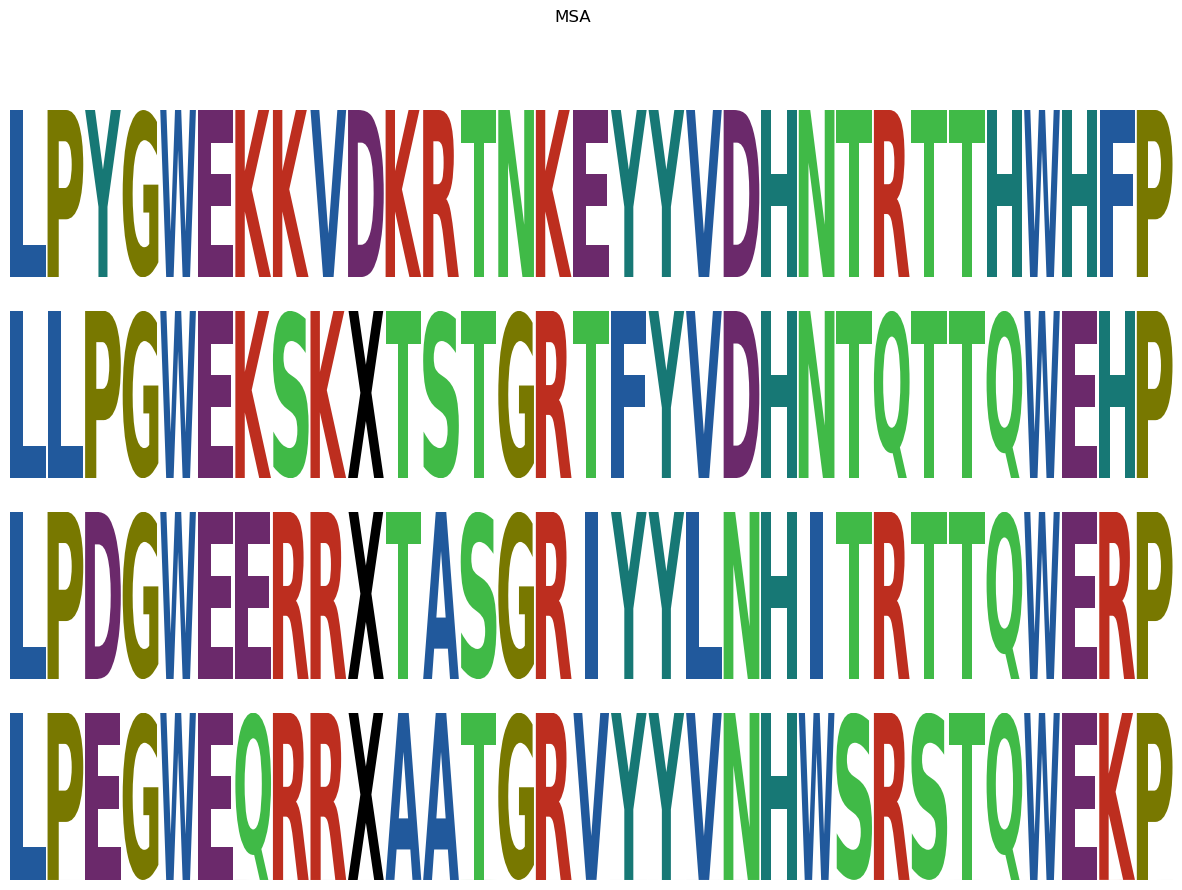

In [6]:
import matplotlib.pyplot as plt
import src.gp_cpab.src.extra.utilities as ut
import matplotlib.gridspec as gridspec
import logomaker 


def get_GPinterpolation(TT, theta, Y, Ug,  n_batch, grid_length_for_GP, seq_len):
    grids_trans_out = (TT.transform_grid(TT.grid,theta)*(seq_len - 1)).squeeze(1)
    # creating the likelihood for interpolation
    batch_Multitask_model, batch_multitask_likelihood = TT.sets_MultioutputGP_per_batches(grids_trans_out, Y, n_batch)
    # To get distribution over Posteriors
    trans_data, _, \
            lower,upper  = TT.predict_operation(Ug, batch_Multitask_model, batch_multitask_likelihood  )
    trans_data = torch.reshape(trans_data, (n_batch, grid_length_for_GP, Y.shape[2]))
    lower = torch.reshape( lower, (n_batch, grid_length_for_GP, Y.shape[2]) )
    upper = torch.reshape( upper, (n_batch, grid_length_for_GP, Y.shape[2]) )

    return grids_trans_out, trans_data, lower, upper

def plot_GP_components_per_seq(Ug, gT, Trdata, Lw, Up, nrows, ncols, alphabets, title, fig):

    for j, axs in enumerate(fig.axes[(nrows-1)*ncols : nrows*ncols]):
        axs.plot( Ug.flatten().detach().numpy(), Trdata[:,j].detach().numpy(), 'b' )
        axs.fill_between(Ug.flatten().detach().numpy(), Lw[:,j].detach().numpy(),  Up[:,j].detach().numpy(), alpha=0.3)
        axs.legend([ 'Mean'])
        axs.set_xticks( Ug.flatten().detach().numpy(), minor= True )
        axs.axhline(0, color='grey', linewidth=0.8)
        axs.set_title(alphabets[j])
    
    #fig.tight_layout()
    
 
def create_gridSpec_graphs(ncols=4,nrows=2,figsize=(25,12)):
    fig = plt.figure(figsize=figsize) #(constrained_layout=True)
    gs = gridspec.GridSpec(ncols=ncols, nrows=nrows, figure=fig)
    for i in range(0, nrows):
        for j in range(0,ncols):
            fig.add_subplot(gs[i, j])
    return fig, gs

def plot_GP_components_alignment_channel(Ug,grids_trans_out, trans_data,lower,upper, fig2):
    for cont,(U,gT, Trdata,Lw,Up) in enumerate(list(zip(Ug,grids_trans_out, trans_data,lower,upper))):
        title='sequence {0}'.format(cont+1)
        plot_GP_components_per_seq(U, gT, Trdata, Lw, Up, cont+1, Trdata.shape[1], alphabets=alphabets, title=title, fig = fig2)

def heatmap_from_tensor_tmp(data, alphabet, title):
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    figure, ax = plt.subplots(figsize=(8,10))
    #ax = plt.axes()
    px = pd.DataFrame(data, columns=alphabet)
    ff=sns.heatmap(px, linewidth=1, linecolor='w', annot=data, ax = ax)
    ax.set_title(title)
    plt.show()

def plot_msa_from_preds(ts_aligned, alphabet, figsize = (5,4), show_axis=True):
    fig, gs = create_gridSpec_graphs(ncols=1,nrows=ts_aligned.shape[0], figsize=figsize); fig.suptitle('MSA', fontsize='large')

    alphabets_logo = [ i if i!='-' else 'X' for i in alphabet] 
    for cont, x_aligned in enumerate(ts_aligned):
        domain_info_df = df_construction_aas([ x_aligned.unsqueeze(0).detach().numpy() ], x_aligned.unsqueeze(0).shape, alphabets_logo)
        
        if show_axis == False:
            fig.axes[cont].get_xaxis().set_visible(False)
            fig.axes[cont].get_yaxis().set_visible(False)

        logomaker.Logo(domain_info_df,
                          color_scheme = 'NajafabadiEtAl2017',
                          ax = fig.axes[cont],
                          figsize=figsize, show_spines=False)



# recon_data_train = model(dataset_msa.prot_space, deepseq)
def get_GP_behavior_from_model_alignment(data,model, DS, len_grid = 13 , alphabets=['-','L','Q','R']):
    model.eval()
    Y = data
    recon_data_train = model(data, DS)

    x1_trans = recon_data_train[5]

    out_DS_before_dir_trans = DS(x1_trans)[0]

    TT=model.stn.st_gp_cpab
    TT.interpolation_type = 'GP'
    grid_length_for_GP = len_grid


    #get the transformation from Big model
    _, theta = model.sample_only_trans(Y)
    seq_len = Y.shape[1]; n_batch = Y.shape[0]

    ''' info about initial deformation '''
    '''----------------------------------------------------------------------------------------------------------------------------------------------------------------------'''
    initialTT_raw = TT.grid
    initialTT_inv = TT.transform_grid(TT.grid,-theta)
    initialTT_dir = TT.transform_grid(TT.grid,theta)
    forward = torch.stack([initialTT_raw.flatten() ,initialTT_inv.flatten(), (initialTT_inv*(x1_trans.shape[1]-1)).flatten() ]).T
    backward = torch.stack([initialTT_raw.flatten() ,initialTT_dir.flatten(), (initialTT_dir*(x1_trans.shape[1]-1)).flatten() ]).T
    heatmap_from_tensor_tmp(forward.detach().numpy(), ['input','raw','scaled'], 'FORWARD SCHEME' )
    heatmap_from_tensor_tmp(backward.detach().numpy(), ['input','raw','scaled'], 'BACKWARD SCHEME' )
    '''----------------------------------------------------------------------------------------------------------------------------------------------------------------------'''

    # grid creations and deformations based on theta estimated from big model

    Ug=TT.uniform_meshgrid((grid_length_for_GP,grid_length_for_GP)).repeat(n_batch,1,1)*(seq_len - 1)
    
    grids_trans_out, trans_data, lower, upper = get_GPinterpolation(TT, -theta, Y, Ug, n_batch, grid_length_for_GP, seq_len)
    grids_dir_trans_out, dir_trans_data, lower_dir, upper_dir = get_GPinterpolation(TT, theta, out_DS_before_dir_trans, Ug, n_batch, grid_length_for_GP, seq_len)

    ncols= grids_trans_out.shape[-1]; nrows = Ug.shape[0]
    fig, gs = create_gridSpec_graphs(ncols=ncols,nrows=nrows, figsize=(25,20)); fig.suptitle('Sequence Alignment by Transformation', fontsize='large')
    figdir, gsdir = create_gridSpec_graphs(ncols=ncols,nrows=nrows,figsize=(25,20)); figdir.suptitle('Sequence Reconstruction', fontsize='large')
    
    plot_GP_components_alignment_channel(Ug,grids_trans_out, trans_data,lower,upper, fig)
    plot_GP_components_alignment_channel(Ug,grids_dir_trans_out, dir_trans_data,lower_dir,upper_dir, figdir)



x = deepseq(trainloader_pretrainer.dataset.prot_space)
plot_msa_from_preds(x[0], alphabets, figsize=(15,10), show_axis=False)



In [7]:
import time
def fit_VITAE_with_pretrained_DeepSeq(trainloader, optimizer, model, DS, n_epochs=10, warmup=1, logdir='',
            testloader=None, eq_samples=1, iw_samples=1, beta=1.0, eval_epoch=10000, **kargs):
        """ Fits the supplied model to a training set 
        Arguments:
            trainloader: dataloader (of type torch.utils.data.DataLoader) that
                contains the training data
            n_epochs: integer, number of epochs to run
            warmup: integer, the KL terms are weighted by epoch/warmup, so this
                number determines the number of epochs before the KL-terms are 
                fully activated in the loss function
            logdir: str, where to store the results
            testloader: dataloader (of type torch.utils.data.DataLoader) that
                contains the test data
            eq_samples: integer, number of equality samples which the expectation
                is calculated over
            iw_samples: integer, number of samples the mean-log is calculated over
            eval_epoch: how many epochs that should pass between calculating the
                L5000 loglikelihood (very expensive to do)
        """

        # Assert that input is okay
        assert isinstance(trainloader, torch.utils.data.DataLoader), '''Trainloader
            should be an instance of torch.utils.data.DataLoader '''
        assert warmup <= n_epochs, ''' Warmup period need to be smaller than the
            number of epochs '''
    
        # Print stats
        print('Number of training points: ', len(trainloader.dataset.prot_space))
        if testloader: print('Number of test points:     ', len(testloader.dataset))
        
        loss_function = LossFunctionsAlternatives()


        # Main loop
        start = time.time()
        for epoch in range(1, n_epochs+1):
            progress_bar = tqdm(desc='Epoch ' + str(epoch) + '/' + str(n_epochs), 
                                total=len(trainloader.dataset), unit='samples')
            train_loss = 0
            # Training loop
            #self.model.train()
            for i, data in enumerate(trainloader):
                # Zero gradient
                optimizer.zero_grad()
                #import pdb;pdb.set_trace()
                # Feed forward data
                data = data.to(torch.float32).to(device)

                switch = 1.0 if epoch > warmup else 0.0
                out = model(data, DS, eq_samples, iw_samples, switch)
                
                # Calculat loss
                loss = loss_function(method = 'CE', input = out[0], target = data, forw_per=(0,2,1))  - out[7]
                #loss = loss_function(method = 'JSD', input = out[0], target = data, forw_per=(0,2,1)) # - out[7]

                
                # Backpropegate and optimize
                loss.backward()
                optimizer.step()
                
                # Write to consoeeeddddddddwwww######hhhdffffffffffsssswqqq#l#
                progress_bar.update(data.size(0))
                progress_bar.set_postfix({'loss': loss.item()})
                
                # Save to tensorboard
                iteration = epoch*len(trainloader) + i
                
                gc.collect()
                torch.cuda.empty_cache()

            progress_bar.close()
        
        print('Total train time', time.time() - start)
        #import pdb;pdb.set_trace()
        # Save the embeddings

In [8]:

# Construct model
# I do not add the pretrained deepsequence module to avoid 
# the backpropagation of such module during the optimization
model = vitae_ci_gp_no_deepseq(
                    input_shape = seq_size, #img_size,
                    config = std, 
                    latent_dim = args.latent_dim, 
                    encoder = get_encoder( args.ed_type.split(",")[0] ), 
                    decoder = get_decoder( args.ed_type.split(",")[1] ),
                    outputdensity = args.density,
                    ST_type = args.stn_type,
                    alphabet_size = len(c2i),
                    trans_parameters = ( [window_grid], device, gp_params ) )

#model.get_deepsequence_module(deepseq)

# Optimizer
opt = torch.optim.AdamW(model.parameters(), lr=1e-4)#, weight_decay=1e-6) #lr=1e-3 and weigh_dacay1e-6 - 1e-7 in that range is working for such examples
model_name = '/trained_model_softmax.pt'

fit_VITAE_with_pretrained_DeepSeq(trainloader, opt, model, deepseq, n_epochs=1000, warmup=1, logdir='',
            testloader=None, eq_samples=1, iw_samples=1, beta=1.0, eval_epoch=10)

Number of training points:  4


Epoch 1/1000:   0%|                                                                                         | 0/4 [00:00<?, ?samples/s]

/workspaces/Explicit_Disentanglement_Proteins/src/models/experimental/vitae_ci_gp_detached_deepseq.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_mean = torch.tensor(x_mean_no_grad, requires_grad=True)
/workspaces/Explicit_Disentanglement_Proteins/src/models/experimental/vitae_ci_gp_detached_deepseq.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_var = torch.tensor(x_var_no_grad, requires_grad=True)


Epoch 1/1000: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.44samples/s]

Epoch 1/1000: 100%|███████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.44samples/s, loss=341]

Epoch 1/1000: 100%|███████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.85samples/s, loss=341]

Epoch 2/1000:   0%|                                                                                         | 0/4 [00:00<?, ?samples/s]

Epoch 2/1000: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.01samples/s]

Epoch 2/1000: 100%|███████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.01samples/s, loss=337]

Epoch 2/1000: 100%|███████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.19samples/s, loss=337]

Epoch 3/1000:   0%|                                                                                         | 0/4 [00:00<?, ?samples/s]

Epoch 3/1000: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.87samples/s]

Epoch 3/1000: 100%|███████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.87samples/s, loss=325]

Epoch 3/1000: 100%|███████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.40samples/s, loss=325]

Epoch 4/1000:   0%|                                                                                         | 0/4 [00:00<?, ?samples/s]

Epoch 4/1000: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.54samples/s]

Epoch 4/1000: 100%|███████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.54samples/s, loss=334]

Epoch 4/1000: 100%|███████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.77samples/s, loss=334]

Epoch 5/1000:   0%|                                                                                         | 0/4 [00:00<?, ?samples/s]

Epoch 5/1000: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.13samples/s]

Epoch 5/1000: 100%|███████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.13samples/s, loss=333]

Epoch 5/1000: 100%|███████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.48samples/s, loss=333]

Epoch 6/1000:   0%|                                                                                         | 0/4 [00:00<?, ?samples/s]

Epoch 6/1000: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.81samples/s]

Epoch 6/1000: 100%|███████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.81samples/s, loss=326]

Epoch 6/1000: 100%|███████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.37samples/s, loss=326]

Epoch 7/1000:   0%|                                                                                         | 0/4 [00:00<?, ?samples/s]

Epoch 7/1000: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.50samples/s]

Epoch 7/1000: 100%|███████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.50samples/s, loss=348]

Epoch 7/1000: 100%|███████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.37samples/s, loss=348]

Epoch 8/1000:   0%|                                                                                         | 0/4 [00:00<?, ?samples/s]

Epoch 8/1000: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.25samples/s]

Epoch 8/1000: 100%|███████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.25samples/s, loss=332]

Epoch 8/1000: 100%|███████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.20samples/s, loss=332]

Epoch 9/1000:   0%|                                                                                         | 0/4 [00:00<?, ?samples/s]

Epoch 9/1000: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.16samples/s]

Epoch 9/1000: 100%|███████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.16samples/s, loss=328]

Epoch 9/1000: 100%|███████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.53samples/s, loss=328]

Epoch 10/1000:   0%|                                                                                        | 0/4 [00:00<?, ?samples/s]

Epoch 10/1000: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.23samples/s]

Epoch 10/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.23samples/s, loss=355]

Epoch 10/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.92samples/s, loss=355]

Epoch 11/1000:   0%|                                                                                        | 0/4 [00:00<?, ?samples/s]

Epoch 11/1000: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.64samples/s]

Epoch 11/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.64samples/s, loss=339]

Epoch 11/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.38samples/s, loss=339]

Epoch 12/1000:   0%|                                                                                        | 0/4 [00:00<?, ?samples/s]

Epoch 12/1000: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.28samples/s]

Epoch 12/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.28samples/s, loss=354]

Epoch 12/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.76samples/s, loss=354]

Epoch 13/1000:   0%|                                                                                        | 0/4 [00:00<?, ?samples/s]

Epoch 13/1000: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.46samples/s]

Epoch 13/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.46samples/s, loss=334]

Epoch 13/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.85samples/s, loss=334]

Epoch 14/1000:   0%|                                                                                        | 0/4 [00:00<?, ?samples/s]

Epoch 14/1000: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.24samples/s]

Epoch 14/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.24samples/s, loss=322]

Epoch 14/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.60samples/s, loss=322]

Epoch 15/1000:   0%|                                                                                        | 0/4 [00:00<?, ?samples/s]

Epoch 15/1000: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.00samples/s]

Epoch 15/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.00samples/s, loss=330]

Epoch 15/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.26samples/s, loss=330]

Epoch 16/1000:   0%|                                                                                        | 0/4 [00:00<?, ?samples/s]

Epoch 16/1000: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.99samples/s]

Epoch 16/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.99samples/s, loss=334]

Epoch 16/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.53samples/s, loss=334]

Epoch 17/1000:   0%|                                                                                        | 0/4 [00:00<?, ?samples/s]

Epoch 17/1000: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.05samples/s]

Epoch 17/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.05samples/s, loss=342]

Epoch 17/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.22samples/s, loss=342]

Epoch 18/1000:   0%|                                                                                        | 0/4 [00:00<?, ?samples/s]

Epoch 18/1000: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.64samples/s]

Epoch 18/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.64samples/s, loss=329]

Epoch 18/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.23samples/s, loss=329]

Epoch 19/1000:   0%|                                                                                        | 0/4 [00:00<?, ?samples/s]

Epoch 19/1000: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.50samples/s]

Epoch 19/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.50samples/s, loss=320]

Epoch 19/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.61samples/s, loss=320]

Epoch 20/1000:   0%|                                                                                        | 0/4 [00:00<?, ?samples/s]

Epoch 20/1000: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.33samples/s]

Epoch 20/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.33samples/s, loss=338]

Epoch 20/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.76samples/s, loss=338]

Epoch 21/1000:   0%|                                                                                        | 0/4 [00:00<?, ?samples/s]

Epoch 21/1000: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.94samples/s]

Epoch 21/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.94samples/s, loss=329]

Epoch 21/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.32samples/s, loss=329]

Epoch 22/1000:   0%|                                                                                        | 0/4 [00:00<?, ?samples/s]

Epoch 22/1000: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.36samples/s]

Epoch 22/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.36samples/s, loss=334]

Epoch 22/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.98samples/s, loss=334]

Epoch 23/1000:   0%|                                                                                        | 0/4 [00:00<?, ?samples/s]

Epoch 23/1000: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.84samples/s]

Epoch 23/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.84samples/s, loss=328]

Epoch 23/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.36samples/s, loss=328]

Epoch 24/1000:   0%|                                                                                        | 0/4 [00:00<?, ?samples/s]

Epoch 24/1000: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.92samples/s]

Epoch 24/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.92samples/s, loss=335]

Epoch 24/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.04samples/s, loss=335]

Epoch 25/1000:   0%|                                                                                        | 0/4 [00:00<?, ?samples/s]

Epoch 25/1000: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.26samples/s]

Epoch 25/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.26samples/s, loss=319]

Epoch 25/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.77samples/s, loss=319]

Epoch 26/1000:   0%|                                                                                        | 0/4 [00:00<?, ?samples/s]

Epoch 26/1000: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.44samples/s]

Epoch 26/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.44samples/s, loss=330]

Epoch 26/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.80samples/s, loss=330]

Epoch 27/1000:   0%|                                                                                        | 0/4 [00:00<?, ?samples/s]

Epoch 27/1000: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.91samples/s]

Epoch 27/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.91samples/s, loss=336]

Epoch 27/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.33samples/s, loss=336]

Epoch 28/1000:   0%|                                                                                        | 0/4 [00:00<?, ?samples/s]

Epoch 28/1000: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.11samples/s]

Epoch 28/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.11samples/s, loss=310]

Epoch 28/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.54samples/s, loss=310]

Epoch 29/1000:   0%|                                                                                        | 0/4 [00:00<?, ?samples/s]

Epoch 29/1000: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.91samples/s]

Epoch 29/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.91samples/s, loss=326]

Epoch 29/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.21samples/s, loss=326]

Epoch 30/1000:   0%|                                                                                        | 0/4 [00:00<?, ?samples/s]

Epoch 30/1000: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.27samples/s]

Epoch 30/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.27samples/s, loss=314]

Epoch 30/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.53samples/s, loss=314]

Epoch 31/1000:   0%|                                                                                        | 0/4 [00:00<?, ?samples/s]

Epoch 31/1000: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.55samples/s]

Epoch 31/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.55samples/s, loss=355]

Epoch 31/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.84samples/s, loss=355]

Epoch 32/1000:   0%|                                                                                        | 0/4 [00:00<?, ?samples/s]

Epoch 32/1000: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.73samples/s]

Epoch 32/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.73samples/s, loss=335]

Epoch 32/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.56samples/s, loss=335]

Epoch 33/1000:   0%|                                                                                        | 0/4 [00:00<?, ?samples/s]

Epoch 33/1000: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.89samples/s]

Epoch 33/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.89samples/s, loss=332]

Epoch 33/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.37samples/s, loss=332]

Epoch 34/1000:   0%|                                                                                        | 0/4 [00:00<?, ?samples/s]

Epoch 34/1000: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.73samples/s]

Epoch 34/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.73samples/s, loss=308]

Epoch 34/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.95samples/s, loss=308]

Epoch 35/1000:   0%|                                                                                        | 0/4 [00:00<?, ?samples/s]

Epoch 35/1000: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.55samples/s]

Epoch 35/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.55samples/s, loss=325]

Epoch 35/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.80samples/s, loss=325]

Epoch 36/1000:   0%|                                                                                        | 0/4 [00:00<?, ?samples/s]

Epoch 36/1000: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.48samples/s]

Epoch 36/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.48samples/s, loss=319]

Epoch 36/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.80samples/s, loss=319]

Epoch 37/1000:   0%|                                                                                        | 0/4 [00:00<?, ?samples/s]

Epoch 37/1000: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.11samples/s]

Epoch 37/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.11samples/s, loss=323]

Epoch 37/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.48samples/s, loss=323]

Epoch 38/1000:   0%|                                                                                        | 0/4 [00:00<?, ?samples/s]

Epoch 38/1000: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.23samples/s]

Epoch 38/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.23samples/s, loss=320]

Epoch 38/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.59samples/s, loss=320]

Epoch 39/1000:   0%|                                                                                        | 0/4 [00:00<?, ?samples/s]

Epoch 39/1000: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.86samples/s]

Epoch 39/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.86samples/s, loss=347]

Epoch 39/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.09samples/s, loss=347]

Epoch 40/1000:   0%|                                                                                        | 0/4 [00:00<?, ?samples/s]

Epoch 40/1000: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.95samples/s]

Epoch 40/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.95samples/s, loss=325]

Epoch 40/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.40samples/s, loss=325]

Epoch 41/1000:   0%|                                                                                        | 0/4 [00:00<?, ?samples/s]

Epoch 41/1000: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.92samples/s]

Epoch 41/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.92samples/s, loss=336]

Epoch 41/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.36samples/s, loss=336]

Epoch 42/1000:   0%|                                                                                        | 0/4 [00:00<?, ?samples/s]

Epoch 42/1000: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.67samples/s]

Epoch 42/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.67samples/s, loss=334]

Epoch 42/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.93samples/s, loss=334]

Epoch 43/1000:   0%|                                                                                        | 0/4 [00:00<?, ?samples/s]

Epoch 43/1000: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.59samples/s]

Epoch 43/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.59samples/s, loss=315]

Epoch 43/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.84samples/s, loss=315]

Epoch 44/1000:   0%|                                                                                        | 0/4 [00:00<?, ?samples/s]

Epoch 44/1000: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.66samples/s]

Epoch 44/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.66samples/s, loss=315]

Epoch 44/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.21samples/s, loss=315]

Epoch 45/1000:   0%|                                                                                        | 0/4 [00:00<?, ?samples/s]

Epoch 45/1000: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.86samples/s]

Epoch 45/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.86samples/s, loss=326]

Epoch 45/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.07samples/s, loss=326]

Epoch 46/1000:   0%|                                                                                        | 0/4 [00:00<?, ?samples/s]

Epoch 46/1000: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.47samples/s]

Epoch 46/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.47samples/s, loss=314]

Epoch 46/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.09samples/s, loss=314]

Epoch 47/1000:   0%|                                                                                        | 0/4 [00:00<?, ?samples/s]

Epoch 47/1000: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.42samples/s]

Epoch 47/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.42samples/s, loss=308]

Epoch 47/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.14samples/s, loss=308]

Epoch 48/1000:   0%|                                                                                        | 0/4 [00:00<?, ?samples/s]

Epoch 48/1000: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.42samples/s]

Epoch 48/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.42samples/s, loss=321]

Epoch 48/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.38samples/s, loss=321]

Epoch 49/1000:   0%|                                                                                        | 0/4 [00:00<?, ?samples/s]

Epoch 49/1000: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.84samples/s]

Epoch 49/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.84samples/s, loss=308]

Epoch 49/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.25samples/s, loss=308]

Epoch 50/1000:   0%|                                                                                        | 0/4 [00:00<?, ?samples/s]

Epoch 50/1000: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.38samples/s]

Epoch 50/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.38samples/s, loss=300]

Epoch 50/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.83samples/s, loss=300]

Epoch 51/1000:   0%|                                                                                        | 0/4 [00:00<?, ?samples/s]

Epoch 51/1000: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.09samples/s]

Epoch 51/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.09samples/s, loss=321]

Epoch 51/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.40samples/s, loss=321]

Epoch 52/1000:   0%|                                                                                        | 0/4 [00:00<?, ?samples/s]

Epoch 52/1000: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.90samples/s]

Epoch 52/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.90samples/s, loss=320]

Epoch 52/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.45samples/s, loss=320]

Epoch 53/1000:   0%|                                                                                        | 0/4 [00:00<?, ?samples/s]

Epoch 53/1000: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.77samples/s]

Epoch 53/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.77samples/s, loss=310]

Epoch 53/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.51samples/s, loss=310]

Epoch 54/1000:   0%|                                                                                        | 0/4 [00:00<?, ?samples/s]

Epoch 54/1000: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.21samples/s]

Epoch 54/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.21samples/s, loss=325]

Epoch 54/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.45samples/s, loss=325]

Epoch 55/1000:   0%|                                                                                        | 0/4 [00:00<?, ?samples/s]

Epoch 55/1000: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.93samples/s]

Epoch 55/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.93samples/s, loss=311]

Epoch 55/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.14samples/s, loss=311]

Epoch 56/1000:   0%|                                                                                        | 0/4 [00:00<?, ?samples/s]

Epoch 56/1000: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.52samples/s]

Epoch 56/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.52samples/s, loss=328]

Epoch 56/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.58samples/s, loss=328]

Epoch 57/1000:   0%|                                                                                        | 0/4 [00:00<?, ?samples/s]

Epoch 57/1000: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.35samples/s]

Epoch 57/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.35samples/s, loss=334]

Epoch 57/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.68samples/s, loss=334]

Epoch 58/1000:   0%|                                                                                        | 0/4 [00:00<?, ?samples/s]

Epoch 58/1000: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.86samples/s]

Epoch 58/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.86samples/s, loss=327]

Epoch 58/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.34samples/s, loss=327]

Epoch 59/1000:   0%|                                                                                        | 0/4 [00:00<?, ?samples/s]

Epoch 59/1000: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.45samples/s]

Epoch 59/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.45samples/s, loss=323]

Epoch 59/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.77samples/s, loss=323]

Epoch 60/1000:   0%|                                                                                        | 0/4 [00:00<?, ?samples/s]

Epoch 60/1000: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.17samples/s]

Epoch 60/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.17samples/s, loss=329]

Epoch 60/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.86samples/s, loss=329]

Epoch 61/1000:   0%|                                                                                        | 0/4 [00:00<?, ?samples/s]

Epoch 61/1000: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.48samples/s]

Epoch 61/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.48samples/s, loss=328]

Epoch 61/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.81samples/s, loss=328]

Epoch 62/1000:   0%|                                                                                        | 0/4 [00:00<?, ?samples/s]

Epoch 62/1000: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.81samples/s]

Epoch 62/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.81samples/s, loss=317]

Epoch 62/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.31samples/s, loss=317]

Epoch 63/1000:   0%|                                                                                        | 0/4 [00:00<?, ?samples/s]

Epoch 63/1000: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.48samples/s]

Epoch 63/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.48samples/s, loss=325]

Epoch 63/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.79samples/s, loss=325]

Epoch 64/1000:   0%|                                                                                        | 0/4 [00:00<?, ?samples/s]

Epoch 64/1000: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.15samples/s]

Epoch 64/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.15samples/s, loss=327]

Epoch 64/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.56samples/s, loss=327]

Epoch 65/1000:   0%|                                                                                        | 0/4 [00:00<?, ?samples/s]

Epoch 65/1000: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.89samples/s]

Epoch 65/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.89samples/s, loss=306]

Epoch 65/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.06samples/s, loss=306]

Epoch 66/1000:   0%|                                                                                        | 0/4 [00:00<?, ?samples/s]

Epoch 66/1000: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.49samples/s]

Epoch 66/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.49samples/s, loss=342]

Epoch 66/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.80samples/s, loss=342]

Epoch 67/1000:   0%|                                                                                        | 0/4 [00:00<?, ?samples/s]

Epoch 67/1000: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.60samples/s]

Epoch 67/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.60samples/s, loss=308]

Epoch 67/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.87samples/s, loss=308]

Epoch 68/1000:   0%|                                                                                        | 0/4 [00:00<?, ?samples/s]

Epoch 68/1000: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.46samples/s]

Epoch 68/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.46samples/s, loss=310]

Epoch 68/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.79samples/s, loss=310]

Epoch 69/1000:   0%|                                                                                        | 0/4 [00:00<?, ?samples/s]

Epoch 69/1000: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.36samples/s]

Epoch 69/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.36samples/s, loss=305]

Epoch 69/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.95samples/s, loss=305]

Epoch 70/1000:   0%|                                                                                        | 0/4 [00:00<?, ?samples/s]

Epoch 70/1000: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.28samples/s]

Epoch 70/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.28samples/s, loss=302]

Epoch 70/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.61samples/s, loss=302]

Epoch 71/1000:   0%|                                                                                        | 0/4 [00:00<?, ?samples/s]

Epoch 71/1000: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.81samples/s]

Epoch 71/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.81samples/s, loss=325]

Epoch 71/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.34samples/s, loss=325]

Epoch 72/1000:   0%|                                                                                        | 0/4 [00:00<?, ?samples/s]

Epoch 72/1000: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.12samples/s]

Epoch 72/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.12samples/s, loss=325]

Epoch 72/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.55samples/s, loss=325]

Epoch 73/1000:   0%|                                                                                        | 0/4 [00:00<?, ?samples/s]

Epoch 73/1000: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.55samples/s]

Epoch 73/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.55samples/s, loss=323]

Epoch 73/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.85samples/s, loss=323]

Epoch 74/1000:   0%|                                                                                        | 0/4 [00:00<?, ?samples/s]

Epoch 74/1000: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.37samples/s]

Epoch 74/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.37samples/s, loss=317]

Epoch 74/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.70samples/s, loss=317]

Epoch 75/1000:   0%|                                                                                        | 0/4 [00:00<?, ?samples/s]

Epoch 75/1000: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.54samples/s]

Epoch 75/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.54samples/s, loss=307]

Epoch 75/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.38samples/s, loss=307]

Epoch 76/1000:   0%|                                                                                        | 0/4 [00:00<?, ?samples/s]

Epoch 76/1000: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.67samples/s]

Epoch 76/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.67samples/s, loss=313]

Epoch 76/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.92samples/s, loss=313]

Epoch 77/1000:   0%|                                                                                        | 0/4 [00:00<?, ?samples/s]

Epoch 77/1000: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.59samples/s]

Epoch 77/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.59samples/s, loss=309]

Epoch 77/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.85samples/s, loss=309]

Epoch 78/1000:   0%|                                                                                        | 0/4 [00:00<?, ?samples/s]

Epoch 78/1000: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.50samples/s]

Epoch 78/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.50samples/s, loss=324]

Epoch 78/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.81samples/s, loss=324]

Epoch 79/1000:   0%|                                                                                        | 0/4 [00:00<?, ?samples/s]

Epoch 79/1000: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.11samples/s]

Epoch 79/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.11samples/s, loss=318]

Epoch 79/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.49samples/s, loss=318]

Epoch 80/1000:   0%|                                                                                        | 0/4 [00:00<?, ?samples/s]

Epoch 80/1000: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.75samples/s]

Epoch 80/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.75samples/s, loss=311]

Epoch 80/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.97samples/s, loss=311]

Epoch 81/1000:   0%|                                                                                        | 0/4 [00:00<?, ?samples/s]

Epoch 81/1000: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.75samples/s]

Epoch 81/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.75samples/s, loss=329]

Epoch 81/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.00samples/s, loss=329]

Epoch 82/1000:   0%|                                                                                        | 0/4 [00:00<?, ?samples/s]

Epoch 82/1000: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.87samples/s]

Epoch 82/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.87samples/s, loss=336]

Epoch 82/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.88samples/s, loss=336]

Epoch 83/1000:   0%|                                                                                        | 0/4 [00:00<?, ?samples/s]

Epoch 83/1000: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.51samples/s]

Epoch 83/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.51samples/s, loss=334]

Epoch 83/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.85samples/s, loss=334]

Epoch 84/1000:   0%|                                                                                        | 0/4 [00:00<?, ?samples/s]

Epoch 84/1000: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.38samples/s]

Epoch 84/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.38samples/s, loss=323]

Epoch 84/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.01samples/s, loss=323]

Epoch 85/1000:   0%|                                                                                        | 0/4 [00:00<?, ?samples/s]

Epoch 85/1000: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.57samples/s]

Epoch 85/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.57samples/s, loss=318]

Epoch 85/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.86samples/s, loss=318]

Epoch 86/1000:   0%|                                                                                        | 0/4 [00:00<?, ?samples/s]

Epoch 86/1000: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.37samples/s]

Epoch 86/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.37samples/s, loss=311]

Epoch 86/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.70samples/s, loss=311]

Epoch 87/1000:   0%|                                                                                        | 0/4 [00:00<?, ?samples/s]

Epoch 87/1000: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.36samples/s]

Epoch 87/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.36samples/s, loss=314]

Epoch 87/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.65samples/s, loss=314]

Epoch 88/1000:   0%|                                                                                        | 0/4 [00:00<?, ?samples/s]

Epoch 88/1000: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.56samples/s]

Epoch 88/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.56samples/s, loss=335]

Epoch 88/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.07samples/s, loss=335]

Epoch 89/1000:   0%|                                                                                        | 0/4 [00:00<?, ?samples/s]

Epoch 89/1000: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.07samples/s]

Epoch 89/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.07samples/s, loss=309]

Epoch 89/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.50samples/s, loss=309]

Epoch 90/1000:   0%|                                                                                        | 0/4 [00:00<?, ?samples/s]

Epoch 90/1000: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.26samples/s]

Epoch 90/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.26samples/s, loss=318]

Epoch 90/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.64samples/s, loss=318]

Epoch 91/1000:   0%|                                                                                        | 0/4 [00:00<?, ?samples/s]

Epoch 91/1000: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.26samples/s]

Epoch 91/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.26samples/s, loss=331]

Epoch 91/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.62samples/s, loss=331]

Epoch 92/1000:   0%|                                                                                        | 0/4 [00:00<?, ?samples/s]

Epoch 92/1000: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.94samples/s]

Epoch 92/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.94samples/s, loss=309]

Epoch 92/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.38samples/s, loss=309]

Epoch 93/1000:   0%|                                                                                        | 0/4 [00:00<?, ?samples/s]

Epoch 93/1000: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.15samples/s]

Epoch 93/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.15samples/s, loss=332]

Epoch 93/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.13samples/s, loss=332]

Epoch 94/1000:   0%|                                                                                        | 0/4 [00:00<?, ?samples/s]

Epoch 94/1000: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.37samples/s]

Epoch 94/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.37samples/s, loss=325]

Epoch 94/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.12samples/s, loss=325]

Epoch 95/1000:   0%|                                                                                        | 0/4 [00:00<?, ?samples/s]

Epoch 95/1000: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.73samples/s]

Epoch 95/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.73samples/s, loss=322]

Epoch 95/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.51samples/s, loss=322]

Epoch 96/1000:   0%|                                                                                        | 0/4 [00:00<?, ?samples/s]

Epoch 96/1000: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.10samples/s]

Epoch 96/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.10samples/s, loss=309]

Epoch 96/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.49samples/s, loss=309]

Epoch 97/1000:   0%|                                                                                        | 0/4 [00:00<?, ?samples/s]

Epoch 97/1000: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.25samples/s]

Epoch 97/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.25samples/s, loss=303]

Epoch 97/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.86samples/s, loss=303]

Epoch 98/1000:   0%|                                                                                        | 0/4 [00:00<?, ?samples/s]

Epoch 98/1000: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.08samples/s]

Epoch 98/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.08samples/s, loss=327]

Epoch 98/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.82samples/s, loss=327]

Epoch 99/1000:   0%|                                                                                        | 0/4 [00:00<?, ?samples/s]

Epoch 99/1000: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.08samples/s]

Epoch 99/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.08samples/s, loss=318]

Epoch 99/1000: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.70samples/s, loss=318]

Epoch 100/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 100/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.59samples/s]

Epoch 100/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.59samples/s, loss=329]

Epoch 100/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.32samples/s, loss=329]

Epoch 101/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 101/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.83samples/s]

Epoch 101/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.83samples/s, loss=311]

Epoch 101/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.53samples/s, loss=311]

Epoch 102/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 102/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.60samples/s]

Epoch 102/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.60samples/s, loss=315]

Epoch 102/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.03samples/s, loss=315]

Epoch 103/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 103/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.38samples/s]

Epoch 103/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.38samples/s, loss=326]

Epoch 103/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.01samples/s, loss=326]

Epoch 104/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 104/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.06samples/s]

Epoch 104/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.06samples/s, loss=321]

Epoch 104/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.40samples/s, loss=321]

Epoch 105/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 105/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.85samples/s]

Epoch 105/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.85samples/s, loss=304]

Epoch 105/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.33samples/s, loss=304]

Epoch 106/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 106/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.14samples/s]

Epoch 106/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.14samples/s, loss=333]

Epoch 106/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.17samples/s, loss=333]

Epoch 107/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 107/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.45samples/s]

Epoch 107/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.45samples/s, loss=323]

Epoch 107/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.25samples/s, loss=323]

Epoch 108/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 108/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.14samples/s]

Epoch 108/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.14samples/s, loss=325]

Epoch 108/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.03samples/s, loss=325]

Epoch 109/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 109/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.89samples/s]

Epoch 109/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.89samples/s, loss=319]

Epoch 109/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.55samples/s, loss=319]

Epoch 110/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 110/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.18samples/s]

Epoch 110/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.18samples/s, loss=323]

Epoch 110/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.68samples/s, loss=323]

Epoch 111/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 111/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.96samples/s]

Epoch 111/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.96samples/s, loss=330]

Epoch 111/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.09samples/s, loss=330]

Epoch 112/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 112/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.03samples/s]

Epoch 112/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.03samples/s, loss=324]

Epoch 112/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.95samples/s, loss=324]

Epoch 113/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 113/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.92samples/s]

Epoch 113/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.92samples/s, loss=298]

Epoch 113/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.36samples/s, loss=298]

Epoch 114/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 114/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.81samples/s]

Epoch 114/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.81samples/s, loss=321]

Epoch 114/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.59samples/s, loss=321]

Epoch 115/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 115/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.36samples/s]

Epoch 115/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.36samples/s, loss=323]

Epoch 115/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.82samples/s, loss=323]

Epoch 116/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 116/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.01samples/s]

Epoch 116/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.01samples/s, loss=328]

Epoch 116/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.78samples/s, loss=328]

Epoch 117/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 117/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.77samples/s]

Epoch 117/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.77samples/s, loss=304]

Epoch 117/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.38samples/s, loss=304]

Epoch 118/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 118/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.88samples/s]

Epoch 118/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.88samples/s, loss=307]

Epoch 118/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.36samples/s, loss=307]

Epoch 119/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 119/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.82samples/s]

Epoch 119/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.82samples/s, loss=310]

Epoch 119/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.53samples/s, loss=310]

Epoch 120/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 120/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.57samples/s]

Epoch 120/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.57samples/s, loss=300]

Epoch 120/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.21samples/s, loss=300]

Epoch 121/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 121/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.44samples/s]

Epoch 121/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.44samples/s, loss=310]

Epoch 121/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.03samples/s, loss=310]

Epoch 122/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 122/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.37samples/s]

Epoch 122/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.37samples/s, loss=306]

Epoch 122/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.70samples/s, loss=306]

Epoch 123/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 123/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.46samples/s]

Epoch 123/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.46samples/s, loss=299]

Epoch 123/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.07samples/s, loss=299]

Epoch 124/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 124/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.48samples/s]

Epoch 124/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.48samples/s, loss=305]

Epoch 124/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.79samples/s, loss=305]

Epoch 125/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 125/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.73samples/s]

Epoch 125/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.73samples/s, loss=297]

Epoch 125/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.49samples/s, loss=297]

Epoch 126/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 126/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.00samples/s]

Epoch 126/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.00samples/s, loss=328]

Epoch 126/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.03samples/s, loss=328]

Epoch 127/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 127/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.02samples/s]

Epoch 127/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.02samples/s, loss=320]

Epoch 127/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.10samples/s, loss=320]

Epoch 128/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 128/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.67samples/s]

Epoch 128/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.67samples/s, loss=307]

Epoch 128/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.97samples/s, loss=307]

Epoch 129/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 129/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.87samples/s]

Epoch 129/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.87samples/s, loss=322]

Epoch 129/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.45samples/s, loss=322]

Epoch 130/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 130/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.81samples/s]

Epoch 130/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.81samples/s, loss=308]

Epoch 130/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.87samples/s, loss=308]

Epoch 131/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 131/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.65samples/s]

Epoch 131/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.65samples/s, loss=314]

Epoch 131/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.68samples/s, loss=314]

Epoch 132/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 132/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.79samples/s]

Epoch 132/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.79samples/s, loss=303]

Epoch 132/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.97samples/s, loss=303]

Epoch 133/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 133/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.43samples/s]

Epoch 133/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.43samples/s, loss=310]

Epoch 133/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.91samples/s, loss=310]

Epoch 134/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 134/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.50samples/s]

Epoch 134/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.50samples/s, loss=315]

Epoch 134/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.67samples/s, loss=315]

Epoch 135/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 135/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.38samples/s]

Epoch 135/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.38samples/s, loss=317]

Epoch 135/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.68samples/s, loss=317]

Epoch 136/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 136/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.63samples/s]

Epoch 136/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.63samples/s, loss=309]

Epoch 136/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.71samples/s, loss=309]

Epoch 137/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 137/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.47samples/s]

Epoch 137/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.47samples/s, loss=315]

Epoch 137/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.48samples/s, loss=315]

Epoch 138/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 138/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.51samples/s]

Epoch 138/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.51samples/s, loss=301]

Epoch 138/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.12samples/s, loss=301]

Epoch 139/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 139/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.33samples/s]

Epoch 139/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.33samples/s, loss=312]

Epoch 139/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.69samples/s, loss=312]

Epoch 140/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 140/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.25samples/s]

Epoch 140/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.25samples/s, loss=316]

Epoch 140/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.53samples/s, loss=316]

Epoch 141/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 141/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.40samples/s]

Epoch 141/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.40samples/s, loss=320]

Epoch 141/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.42samples/s, loss=320]

Epoch 142/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 142/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.41samples/s]

Epoch 142/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.41samples/s, loss=309]

Epoch 142/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.16samples/s, loss=309]

Epoch 143/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 143/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.69samples/s]

Epoch 143/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.69samples/s, loss=317]

Epoch 143/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.19samples/s, loss=317]

Epoch 144/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 144/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.57samples/s]

Epoch 144/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.57samples/s, loss=309]

Epoch 144/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.30samples/s, loss=309]

Epoch 145/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 145/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.32samples/s]

Epoch 145/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.32samples/s, loss=301]

Epoch 145/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.95samples/s, loss=301]

Epoch 146/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 146/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.59samples/s]

Epoch 146/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.59samples/s, loss=302]

Epoch 146/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.93samples/s, loss=302]

Epoch 147/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 147/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.28samples/s]

Epoch 147/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.28samples/s, loss=297]

Epoch 147/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.86samples/s, loss=297]

Epoch 148/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 148/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.84samples/s]

Epoch 148/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.84samples/s, loss=307]

Epoch 148/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.79samples/s, loss=307]

Epoch 149/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 149/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.75samples/s]

Epoch 149/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.75samples/s, loss=293]

Epoch 149/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.51samples/s, loss=293]

Epoch 150/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 150/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.27samples/s]

Epoch 150/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.27samples/s, loss=306]

Epoch 150/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.77samples/s, loss=306]

Epoch 151/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 151/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.84samples/s]

Epoch 151/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.84samples/s, loss=308]

Epoch 151/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.81samples/s, loss=308]

Epoch 152/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 152/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.53samples/s]

Epoch 152/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.53samples/s, loss=305]

Epoch 152/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.54samples/s, loss=305]

Epoch 153/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 153/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.72samples/s]

Epoch 153/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.72samples/s, loss=296]

Epoch 153/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.42samples/s, loss=296]

Epoch 154/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 154/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.32samples/s]

Epoch 154/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.32samples/s, loss=302]

Epoch 154/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.88samples/s, loss=302]

Epoch 155/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 155/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.94samples/s]

Epoch 155/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.94samples/s, loss=298]

Epoch 155/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.21samples/s, loss=298]

Epoch 156/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 156/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.75samples/s]

Epoch 156/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.75samples/s, loss=324]

Epoch 156/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.52samples/s, loss=324]

Epoch 157/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 157/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.56samples/s]

Epoch 157/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.56samples/s, loss=318]

Epoch 157/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.59samples/s, loss=318]

Epoch 158/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 158/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.93samples/s]

Epoch 158/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.93samples/s, loss=317]

Epoch 158/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.40samples/s, loss=317]

Epoch 159/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 159/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.96samples/s]

Epoch 159/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.96samples/s, loss=328]

Epoch 159/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.61samples/s, loss=328]

Epoch 160/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 160/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.14samples/s]

Epoch 160/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.14samples/s, loss=299]

Epoch 160/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.68samples/s, loss=299]

Epoch 161/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 161/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.86samples/s]

Epoch 161/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.86samples/s, loss=303]

Epoch 161/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.73samples/s, loss=303]

Epoch 162/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 162/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.87samples/s]

Epoch 162/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.87samples/s, loss=297]

Epoch 162/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.06samples/s, loss=297]

Epoch 163/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 163/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.60samples/s]

Epoch 163/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.60samples/s, loss=308]

Epoch 163/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.76samples/s, loss=308]

Epoch 164/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 164/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.80samples/s]

Epoch 164/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.80samples/s, loss=301]

Epoch 164/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.79samples/s, loss=301]

Epoch 165/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 165/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.17samples/s]

Epoch 165/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.17samples/s, loss=292]

Epoch 165/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.97samples/s, loss=292]

Epoch 166/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 166/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.16samples/s]

Epoch 166/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.16samples/s, loss=294]

Epoch 166/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.80samples/s, loss=294]

Epoch 167/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 167/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.49samples/s]

Epoch 167/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.49samples/s, loss=312]

Epoch 167/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.00samples/s, loss=312]

Epoch 168/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 168/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.67samples/s]

Epoch 168/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.67samples/s, loss=313]

Epoch 168/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.92samples/s, loss=313]

Epoch 169/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 169/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.83samples/s]

Epoch 169/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.83samples/s, loss=297]

Epoch 169/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.62samples/s, loss=297]

Epoch 170/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 170/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.12samples/s]

Epoch 170/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.12samples/s, loss=301]

Epoch 170/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.32samples/s, loss=301]

Epoch 171/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 171/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.61samples/s]

Epoch 171/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.61samples/s, loss=296]

Epoch 171/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.02samples/s, loss=296]

Epoch 172/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 172/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.11samples/s]

Epoch 172/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.11samples/s, loss=299]

Epoch 172/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.76samples/s, loss=299]

Epoch 173/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 173/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.85samples/s]

Epoch 173/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.85samples/s, loss=302]

Epoch 173/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.38samples/s, loss=302]

Epoch 174/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 174/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.18samples/s]

Epoch 174/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.18samples/s, loss=307]

Epoch 174/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.87samples/s, loss=307]

Epoch 175/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 175/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.62samples/s]

Epoch 175/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.62samples/s, loss=305]

Epoch 175/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.92samples/s, loss=305]

Epoch 176/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 176/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.40samples/s]

Epoch 176/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.40samples/s, loss=299]

Epoch 176/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.33samples/s, loss=299]

Epoch 177/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 177/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.33samples/s]

Epoch 177/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.33samples/s, loss=320]

Epoch 177/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.44samples/s, loss=320]

Epoch 178/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 178/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.52samples/s]

Epoch 178/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.52samples/s, loss=299]

Epoch 178/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.04samples/s, loss=299]

Epoch 179/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 179/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.38samples/s]

Epoch 179/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.38samples/s, loss=292]

Epoch 179/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.76samples/s, loss=292]

Epoch 180/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 180/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.38samples/s]

Epoch 180/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.38samples/s, loss=304]

Epoch 180/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.17samples/s, loss=304]

Epoch 181/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 181/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.27samples/s]

Epoch 181/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.27samples/s, loss=294]

Epoch 181/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.73samples/s, loss=294]

Epoch 182/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 182/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.99samples/s]

Epoch 182/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.99samples/s, loss=293]

Epoch 182/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.84samples/s, loss=293]

Epoch 183/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 183/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.82samples/s]

Epoch 183/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.82samples/s, loss=292]

Epoch 183/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.75samples/s, loss=292]

Epoch 184/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 184/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.91samples/s]

Epoch 184/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.91samples/s, loss=303]

Epoch 184/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.64samples/s, loss=303]

Epoch 185/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 185/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.38samples/s]

Epoch 185/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.38samples/s, loss=292]

Epoch 185/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.91samples/s, loss=292]

Epoch 186/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 186/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.76samples/s]

Epoch 186/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.76samples/s, loss=295]

Epoch 186/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.27samples/s, loss=295]

Epoch 187/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 187/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.39samples/s]

Epoch 187/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.39samples/s, loss=310]

Epoch 187/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.68samples/s, loss=310]

Epoch 188/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 188/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.17samples/s]

Epoch 188/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.17samples/s, loss=299]

Epoch 188/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.31samples/s, loss=299]

Epoch 189/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 189/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.89samples/s]

Epoch 189/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.89samples/s, loss=296]

Epoch 189/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.36samples/s, loss=296]

Epoch 190/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 190/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.36samples/s]

Epoch 190/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.36samples/s, loss=298]

Epoch 190/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.64samples/s, loss=298]

Epoch 191/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 191/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.99samples/s]

Epoch 191/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.99samples/s, loss=301]

Epoch 191/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.78samples/s, loss=301]

Epoch 192/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 192/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.93samples/s]

Epoch 192/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.93samples/s, loss=291]

Epoch 192/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.67samples/s, loss=291]

Epoch 193/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 193/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.96samples/s]

Epoch 193/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.96samples/s, loss=298]

Epoch 193/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.51samples/s, loss=298]

Epoch 194/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 194/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.06samples/s]

Epoch 194/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.06samples/s, loss=294]

Epoch 194/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.76samples/s, loss=294]

Epoch 195/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 195/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.92samples/s]

Epoch 195/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.92samples/s, loss=297]

Epoch 195/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.32samples/s, loss=297]

Epoch 196/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 196/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.03samples/s]

Epoch 196/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.03samples/s, loss=291]

Epoch 196/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.17samples/s, loss=291]

Epoch 197/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 197/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.69samples/s]

Epoch 197/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.69samples/s, loss=301]

Epoch 197/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.50samples/s, loss=301]

Epoch 198/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 198/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.44samples/s]

Epoch 198/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.44samples/s, loss=293]

Epoch 198/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.83samples/s, loss=293]

Epoch 199/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 199/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.28samples/s]

Epoch 199/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.28samples/s, loss=292]

Epoch 199/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.66samples/s, loss=292]

Epoch 200/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 200/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.96samples/s]

Epoch 200/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.96samples/s, loss=299]

Epoch 200/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.06samples/s, loss=299]

Epoch 201/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 201/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.46samples/s]

Epoch 201/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.46samples/s, loss=288]

Epoch 201/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.78samples/s, loss=288]

Epoch 202/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 202/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.28samples/s]

Epoch 202/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.28samples/s, loss=302]

Epoch 202/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.64samples/s, loss=302]

Epoch 203/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 203/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.70samples/s]

Epoch 203/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.70samples/s, loss=296]

Epoch 203/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.91samples/s, loss=296]

Epoch 204/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 204/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.33samples/s]

Epoch 204/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.33samples/s, loss=290]

Epoch 204/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.60samples/s, loss=290]

Epoch 205/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 205/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.56samples/s]

Epoch 205/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.56samples/s, loss=288]

Epoch 205/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.79samples/s, loss=288]

Epoch 206/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 206/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.25samples/s]

Epoch 206/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.25samples/s, loss=291]

Epoch 206/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.65samples/s, loss=291]

Epoch 207/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 207/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.66samples/s]

Epoch 207/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.66samples/s, loss=299]

Epoch 207/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.21samples/s, loss=299]

Epoch 208/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 208/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.42samples/s]

Epoch 208/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.42samples/s, loss=292]

Epoch 208/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.72samples/s, loss=292]

Epoch 209/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 209/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.90samples/s]

Epoch 209/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.90samples/s, loss=308]

Epoch 209/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.11samples/s, loss=308]

Epoch 210/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 210/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.56samples/s]

Epoch 210/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.56samples/s, loss=303]

Epoch 210/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.81samples/s, loss=303]

Epoch 211/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 211/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.98samples/s]

Epoch 211/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.98samples/s, loss=299]

Epoch 211/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.42samples/s, loss=299]

Epoch 212/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 212/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.65samples/s]

Epoch 212/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.65samples/s, loss=297]

Epoch 212/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.93samples/s, loss=297]

Epoch 213/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 213/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.83samples/s]

Epoch 213/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.83samples/s, loss=291]

Epoch 213/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.04samples/s, loss=291]

Epoch 214/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 214/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.60samples/s]

Epoch 214/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.60samples/s, loss=299]

Epoch 214/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.87samples/s, loss=299]

Epoch 215/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 215/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.27samples/s]

Epoch 215/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.27samples/s, loss=291]

Epoch 215/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.51samples/s, loss=291]

Epoch 216/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 216/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.59samples/s]

Epoch 216/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.59samples/s, loss=301]

Epoch 216/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.87samples/s, loss=301]

Epoch 217/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 217/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.58samples/s]

Epoch 217/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.58samples/s, loss=300]

Epoch 217/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.87samples/s, loss=300]

Epoch 218/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 218/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.60samples/s]

Epoch 218/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.60samples/s, loss=297]

Epoch 218/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.90samples/s, loss=297]

Epoch 219/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 219/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.08samples/s]

Epoch 219/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.08samples/s, loss=289]

Epoch 219/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.50samples/s, loss=289]

Epoch 220/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 220/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.80samples/s]

Epoch 220/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.80samples/s, loss=294]

Epoch 220/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.29samples/s, loss=294]

Epoch 221/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 221/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.85samples/s]

Epoch 221/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.85samples/s, loss=295]

Epoch 221/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.02samples/s, loss=295]

Epoch 222/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 222/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.04samples/s]

Epoch 222/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.04samples/s, loss=289]

Epoch 222/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.46samples/s, loss=289]

Epoch 223/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 223/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.95samples/s]

Epoch 223/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.95samples/s, loss=294]

Epoch 223/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.39samples/s, loss=294]

Epoch 224/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 224/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.05samples/s]

Epoch 224/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.05samples/s, loss=296]

Epoch 224/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.75samples/s, loss=296]

Epoch 225/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 225/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.65samples/s]

Epoch 225/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.65samples/s, loss=292]

Epoch 225/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.90samples/s, loss=292]

Epoch 226/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 226/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.36samples/s]

Epoch 226/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.36samples/s, loss=289]

Epoch 226/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.72samples/s, loss=289]

Epoch 227/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 227/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.52samples/s]

Epoch 227/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.52samples/s, loss=297]

Epoch 227/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.81samples/s, loss=297]

Epoch 228/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 228/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.82samples/s]

Epoch 228/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.82samples/s, loss=289]

Epoch 228/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.06samples/s, loss=289]

Epoch 229/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 229/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.08samples/s]

Epoch 229/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.08samples/s, loss=291]

Epoch 229/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.79samples/s, loss=291]

Epoch 230/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 230/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.36samples/s]

Epoch 230/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.36samples/s, loss=296]

Epoch 230/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.64samples/s, loss=296]

Epoch 231/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 231/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.50samples/s]

Epoch 231/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.50samples/s, loss=292]

Epoch 231/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.83samples/s, loss=292]

Epoch 232/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 232/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.26samples/s]

Epoch 232/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.26samples/s, loss=293]

Epoch 232/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.60samples/s, loss=293]

Epoch 233/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 233/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.69samples/s]

Epoch 233/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.69samples/s, loss=287]

Epoch 233/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.07samples/s, loss=287]

Epoch 234/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 234/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.38samples/s]

Epoch 234/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.38samples/s, loss=288]

Epoch 234/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.76samples/s, loss=288]

Epoch 235/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 235/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.10samples/s]

Epoch 235/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.10samples/s, loss=291]

Epoch 235/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.49samples/s, loss=291]

Epoch 236/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 236/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.45samples/s]

Epoch 236/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.45samples/s, loss=292]

Epoch 236/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.77samples/s, loss=292]

Epoch 237/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 237/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.75samples/s]

Epoch 237/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.75samples/s, loss=292]

Epoch 237/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.29samples/s, loss=292]

Epoch 238/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 238/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.29samples/s]

Epoch 238/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.29samples/s, loss=288]

Epoch 238/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.69samples/s, loss=288]

Epoch 239/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 239/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.60samples/s]

Epoch 239/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.60samples/s, loss=298]

Epoch 239/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.90samples/s, loss=298]

Epoch 240/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 240/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.76samples/s]

Epoch 240/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.76samples/s, loss=289]

Epoch 240/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.29samples/s, loss=289]

Epoch 241/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 241/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.60samples/s]

Epoch 241/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.60samples/s, loss=285]

Epoch 241/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.44samples/s, loss=285]

Epoch 242/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 242/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.63samples/s]

Epoch 242/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.63samples/s, loss=289]

Epoch 242/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.88samples/s, loss=289]

Epoch 243/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 243/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.93samples/s]

Epoch 243/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.93samples/s, loss=290]

Epoch 243/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.40samples/s, loss=290]

Epoch 244/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 244/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.68samples/s]

Epoch 244/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.68samples/s, loss=287]

Epoch 244/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.20samples/s, loss=287]

Epoch 245/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 245/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.74samples/s]

Epoch 245/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.74samples/s, loss=291]

Epoch 245/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.98samples/s, loss=291]

Epoch 246/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 246/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.74samples/s]

Epoch 246/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.74samples/s, loss=285]

Epoch 246/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.46samples/s, loss=285]

Epoch 247/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 247/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.68samples/s]

Epoch 247/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.68samples/s, loss=287]

Epoch 247/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.98samples/s, loss=287]

Epoch 248/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 248/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.95samples/s]

Epoch 248/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.95samples/s, loss=289]

Epoch 248/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.61samples/s, loss=289]

Epoch 249/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 249/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.68samples/s]

Epoch 249/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.68samples/s, loss=290]

Epoch 249/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.16samples/s, loss=290]

Epoch 250/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 250/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.87samples/s]

Epoch 250/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.87samples/s, loss=286]

Epoch 250/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.29samples/s, loss=286]

Epoch 251/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 251/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.75samples/s]

Epoch 251/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.75samples/s, loss=288]

Epoch 251/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.00samples/s, loss=288]

Epoch 252/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 252/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.50samples/s]

Epoch 252/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.50samples/s, loss=288]

Epoch 252/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.33samples/s, loss=288]

Epoch 253/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 253/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.95samples/s]

Epoch 253/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.95samples/s, loss=294]

Epoch 253/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.33samples/s, loss=294]

Epoch 254/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 254/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.88samples/s]

Epoch 254/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.88samples/s, loss=286]

Epoch 254/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.38samples/s, loss=286]

Epoch 255/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 255/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.57samples/s]

Epoch 255/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.57samples/s, loss=287]

Epoch 255/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.82samples/s, loss=287]

Epoch 256/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 256/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.50samples/s]

Epoch 256/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.50samples/s, loss=286]

Epoch 256/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.80samples/s, loss=286]

Epoch 257/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 257/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.77samples/s]

Epoch 257/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.77samples/s, loss=287]

Epoch 257/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.96samples/s, loss=287]

Epoch 258/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 258/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.35samples/s]

Epoch 258/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.35samples/s, loss=285]

Epoch 258/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.70samples/s, loss=285]

Epoch 259/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 259/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.76samples/s]

Epoch 259/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.76samples/s, loss=290]

Epoch 259/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.71samples/s, loss=290]

Epoch 260/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 260/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.22samples/s]

Epoch 260/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.22samples/s, loss=289]

Epoch 260/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.33samples/s, loss=289]

Epoch 261/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 261/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.67samples/s]

Epoch 261/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.67samples/s, loss=285]

Epoch 261/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.94samples/s, loss=285]

Epoch 262/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 262/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.82samples/s]

Epoch 262/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.82samples/s, loss=290]

Epoch 262/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.04samples/s, loss=290]

Epoch 263/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 263/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.98samples/s]

Epoch 263/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.98samples/s, loss=286]

Epoch 263/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.45samples/s, loss=286]

Epoch 264/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 264/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.73samples/s]

Epoch 264/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.73samples/s, loss=290]

Epoch 264/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.98samples/s, loss=290]

Epoch 265/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 265/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.19samples/s]

Epoch 265/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.19samples/s, loss=285]

Epoch 265/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.60samples/s, loss=285]

Epoch 266/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 266/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.55samples/s]

Epoch 266/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.55samples/s, loss=284]

Epoch 266/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.80samples/s, loss=284]

Epoch 267/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 267/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.97samples/s]

Epoch 267/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.97samples/s, loss=287]

Epoch 267/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.31samples/s, loss=287]

Epoch 268/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 268/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.38samples/s]

Epoch 268/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.38samples/s, loss=286]

Epoch 268/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.89samples/s, loss=286]

Epoch 269/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 269/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.61samples/s]

Epoch 269/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.61samples/s, loss=286]

Epoch 269/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.07samples/s, loss=286]

Epoch 270/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 270/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.16samples/s]

Epoch 270/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.16samples/s, loss=287]

Epoch 270/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.75samples/s, loss=287]

Epoch 271/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 271/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.39samples/s]

Epoch 271/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.39samples/s, loss=285]

Epoch 271/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.21samples/s, loss=285]

Epoch 272/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 272/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.10samples/s]

Epoch 272/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.10samples/s, loss=285]

Epoch 272/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.69samples/s, loss=285]

Epoch 273/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 273/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.99samples/s]

Epoch 273/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.99samples/s, loss=287]

Epoch 273/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.66samples/s, loss=287]

Epoch 274/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 274/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.98samples/s]

Epoch 274/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.98samples/s, loss=285]

Epoch 274/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.69samples/s, loss=285]

Epoch 275/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 275/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.87samples/s]

Epoch 275/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.87samples/s, loss=285]

Epoch 275/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.58samples/s, loss=285]

Epoch 276/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 276/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.88samples/s]

Epoch 276/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.88samples/s, loss=287]

Epoch 276/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.36samples/s, loss=287]

Epoch 277/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 277/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.89samples/s]

Epoch 277/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.89samples/s, loss=288]

Epoch 277/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.09samples/s, loss=288]

Epoch 278/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 278/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.36samples/s]

Epoch 278/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.36samples/s, loss=285]

Epoch 278/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.73samples/s, loss=285]

Epoch 279/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 279/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.29samples/s]

Epoch 279/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.29samples/s, loss=284]

Epoch 279/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.60samples/s, loss=284]

Epoch 280/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 280/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.84samples/s]

Epoch 280/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.84samples/s, loss=286]

Epoch 280/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.05samples/s, loss=286]

Epoch 281/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 281/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.81samples/s]

Epoch 281/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.81samples/s, loss=287]

Epoch 281/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.03samples/s, loss=287]

Epoch 282/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 282/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.53samples/s]

Epoch 282/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.53samples/s, loss=285]

Epoch 282/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.85samples/s, loss=285]

Epoch 283/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 283/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.68samples/s]

Epoch 283/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.68samples/s, loss=288]

Epoch 283/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.94samples/s, loss=288]

Epoch 284/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 284/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.53samples/s]

Epoch 284/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.53samples/s, loss=285]

Epoch 284/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.11samples/s, loss=285]

Epoch 285/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 285/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.51samples/s]

Epoch 285/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.51samples/s, loss=285]

Epoch 285/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.78samples/s, loss=285]

Epoch 286/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 286/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.66samples/s]

Epoch 286/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.66samples/s, loss=284]

Epoch 286/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.94samples/s, loss=284]

Epoch 287/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 287/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.41samples/s]

Epoch 287/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.41samples/s, loss=289]

Epoch 287/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.70samples/s, loss=289]

Epoch 288/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 288/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.03samples/s]

Epoch 288/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.03samples/s, loss=286]

Epoch 288/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.49samples/s, loss=286]

Epoch 289/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 289/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.36samples/s]

Epoch 289/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.36samples/s, loss=284]

Epoch 289/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.68samples/s, loss=284]

Epoch 290/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 290/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.84samples/s]

Epoch 290/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.84samples/s, loss=285]

Epoch 290/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.02samples/s, loss=285]

Epoch 291/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 291/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.66samples/s]

Epoch 291/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.66samples/s, loss=285]

Epoch 291/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.92samples/s, loss=285]

Epoch 292/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 292/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.53samples/s]

Epoch 292/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.53samples/s, loss=287]

Epoch 292/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.80samples/s, loss=287]

Epoch 293/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 293/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.67samples/s]

Epoch 293/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.67samples/s, loss=285]

Epoch 293/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.21samples/s, loss=285]

Epoch 294/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 294/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.82samples/s]

Epoch 294/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.82samples/s, loss=285]

Epoch 294/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.03samples/s, loss=285]

Epoch 295/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 295/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.24samples/s]

Epoch 295/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.24samples/s, loss=288]

Epoch 295/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.61samples/s, loss=288]

Epoch 296/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 296/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.32samples/s]

Epoch 296/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.32samples/s, loss=284]

Epoch 296/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.70samples/s, loss=284]

Epoch 297/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 297/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.78samples/s]

Epoch 297/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.78samples/s, loss=284]

Epoch 297/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.31samples/s, loss=284]

Epoch 298/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 298/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.73samples/s]

Epoch 298/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.73samples/s, loss=288]

Epoch 298/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.99samples/s, loss=288]

Epoch 299/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 299/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.87samples/s]

Epoch 299/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.87samples/s, loss=289]

Epoch 299/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.09samples/s, loss=289]

Epoch 300/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 300/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.43samples/s]

Epoch 300/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.43samples/s, loss=285]

Epoch 300/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.79samples/s, loss=285]

Epoch 301/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 301/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.24samples/s]

Epoch 301/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.24samples/s, loss=286]

Epoch 301/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.62samples/s, loss=286]

Epoch 302/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 302/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.92samples/s]

Epoch 302/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.92samples/s, loss=284]

Epoch 302/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.09samples/s, loss=284]

Epoch 303/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 303/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.59samples/s]

Epoch 303/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.59samples/s, loss=285]

Epoch 303/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.88samples/s, loss=285]

Epoch 304/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 304/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.51samples/s]

Epoch 304/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.51samples/s, loss=293]

Epoch 304/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.83samples/s, loss=293]

Epoch 305/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 305/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.64samples/s]

Epoch 305/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.64samples/s, loss=286]

Epoch 305/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.89samples/s, loss=286]

Epoch 306/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 306/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.23samples/s]

Epoch 306/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.23samples/s, loss=284]

Epoch 306/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.88samples/s, loss=284]

Epoch 307/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 307/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.62samples/s]

Epoch 307/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.62samples/s, loss=287]

Epoch 307/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.85samples/s, loss=287]

Epoch 308/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 308/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.70samples/s]

Epoch 308/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.70samples/s, loss=287]

Epoch 308/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.94samples/s, loss=287]

Epoch 309/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 309/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.57samples/s]

Epoch 309/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.57samples/s, loss=285]

Epoch 309/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.81samples/s, loss=285]

Epoch 310/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 310/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.40samples/s]

Epoch 310/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.40samples/s, loss=285]

Epoch 310/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.64samples/s, loss=285]

Epoch 311/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 311/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.68samples/s]

Epoch 311/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.68samples/s, loss=289]

Epoch 311/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.97samples/s, loss=289]

Epoch 312/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 312/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.08samples/s]

Epoch 312/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.08samples/s, loss=288]

Epoch 312/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.73samples/s, loss=288]

Epoch 313/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 313/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.63samples/s]

Epoch 313/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.63samples/s, loss=285]

Epoch 313/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.93samples/s, loss=285]

Epoch 314/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 314/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.60samples/s]

Epoch 314/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.60samples/s, loss=284]

Epoch 314/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.87samples/s, loss=284]

Epoch 315/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 315/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.54samples/s]

Epoch 315/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.54samples/s, loss=287]

Epoch 315/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.13samples/s, loss=287]

Epoch 316/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 316/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.88samples/s]

Epoch 316/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.88samples/s, loss=286]

Epoch 316/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.07samples/s, loss=286]

Epoch 317/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 317/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.31samples/s]

Epoch 317/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.31samples/s, loss=287]

Epoch 317/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.70samples/s, loss=287]

Epoch 318/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 318/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.89samples/s]

Epoch 318/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.89samples/s, loss=285]

Epoch 318/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.09samples/s, loss=285]

Epoch 319/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 319/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.91samples/s]

Epoch 319/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.91samples/s, loss=284]

Epoch 319/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.72samples/s, loss=284]

Epoch 320/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 320/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.75samples/s]

Epoch 320/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.75samples/s, loss=286]

Epoch 320/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.67samples/s, loss=286]

Epoch 321/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 321/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.55samples/s]

Epoch 321/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.55samples/s, loss=285]

Epoch 321/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.60samples/s, loss=285]

Epoch 322/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 322/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.00samples/s]

Epoch 322/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.00samples/s, loss=286]

Epoch 322/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.65samples/s, loss=286]

Epoch 323/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 323/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.56samples/s]

Epoch 323/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.56samples/s, loss=283]

Epoch 323/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.16samples/s, loss=283]

Epoch 324/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 324/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.69samples/s]

Epoch 324/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.69samples/s, loss=282]

Epoch 324/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.13samples/s, loss=282]

Epoch 325/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 325/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.18samples/s]

Epoch 325/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.18samples/s, loss=284]

Epoch 325/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.01samples/s, loss=284]

Epoch 326/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 326/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.65samples/s]

Epoch 326/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.65samples/s, loss=285]

Epoch 326/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.46samples/s, loss=285]

Epoch 327/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 327/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.50samples/s]

Epoch 327/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.50samples/s, loss=283]

Epoch 327/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.08samples/s, loss=283]

Epoch 328/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 328/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.04samples/s]

Epoch 328/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.04samples/s, loss=284]

Epoch 328/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.16samples/s, loss=284]

Epoch 329/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 329/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.85samples/s]

Epoch 329/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.85samples/s, loss=284]

Epoch 329/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.03samples/s, loss=284]

Epoch 330/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 330/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.53samples/s]

Epoch 330/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.53samples/s, loss=285]

Epoch 330/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.86samples/s, loss=285]

Epoch 331/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 331/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.49samples/s]

Epoch 331/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.49samples/s, loss=283]

Epoch 331/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.47samples/s, loss=283]

Epoch 332/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 332/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.55samples/s]

Epoch 332/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.55samples/s, loss=284]

Epoch 332/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.32samples/s, loss=284]

Epoch 333/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 333/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.85samples/s]

Epoch 333/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.85samples/s, loss=285]

Epoch 333/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.54samples/s, loss=285]

Epoch 334/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 334/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.66samples/s]

Epoch 334/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.66samples/s, loss=284]

Epoch 334/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.22samples/s, loss=284]

Epoch 335/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 335/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.40samples/s]

Epoch 335/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.40samples/s, loss=283]

Epoch 335/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.46samples/s, loss=283]

Epoch 336/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 336/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.45samples/s]

Epoch 336/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.45samples/s, loss=285]

Epoch 336/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.89samples/s, loss=285]

Epoch 337/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 337/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.08samples/s]

Epoch 337/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.08samples/s, loss=285]

Epoch 337/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.38samples/s, loss=285]

Epoch 338/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 338/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.94samples/s]

Epoch 338/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.94samples/s, loss=286]

Epoch 338/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.13samples/s, loss=286]

Epoch 339/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 339/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.15samples/s]

Epoch 339/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.15samples/s, loss=285]

Epoch 339/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.17samples/s, loss=285]

Epoch 340/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 340/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.23samples/s]

Epoch 340/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.23samples/s, loss=286]

Epoch 340/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.07samples/s, loss=286]

Epoch 341/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 341/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.65samples/s]

Epoch 341/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.65samples/s, loss=284]

Epoch 341/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.13samples/s, loss=284]

Epoch 342/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 342/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.20samples/s]

Epoch 342/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.20samples/s, loss=283]

Epoch 342/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.45samples/s, loss=283]

Epoch 343/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 343/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.39samples/s]

Epoch 343/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.39samples/s, loss=285]

Epoch 343/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.31samples/s, loss=285]

Epoch 344/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 344/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.56samples/s]

Epoch 344/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.56samples/s, loss=285]

Epoch 344/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.27samples/s, loss=285]

Epoch 345/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 345/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.51samples/s]

Epoch 345/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.51samples/s, loss=283]

Epoch 345/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.25samples/s, loss=283]

Epoch 346/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 346/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.96samples/s]

Epoch 346/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.96samples/s, loss=285]

Epoch 346/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.77samples/s, loss=285]

Epoch 347/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 347/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.05samples/s]

Epoch 347/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.05samples/s, loss=286]

Epoch 347/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.50samples/s, loss=286]

Epoch 348/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 348/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.64samples/s]

Epoch 348/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.64samples/s, loss=284]

Epoch 348/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.93samples/s, loss=284]

Epoch 349/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 349/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.40samples/s]

Epoch 349/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.40samples/s, loss=284]

Epoch 349/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.76samples/s, loss=284]

Epoch 350/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 350/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.49samples/s]

Epoch 350/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.49samples/s, loss=284]

Epoch 350/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.81samples/s, loss=284]

Epoch 351/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 351/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.28samples/s]

Epoch 351/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.28samples/s, loss=285]

Epoch 351/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.66samples/s, loss=285]

Epoch 352/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 352/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.81samples/s]

Epoch 352/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.81samples/s, loss=286]

Epoch 352/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.03samples/s, loss=286]

Epoch 353/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 353/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.96samples/s]

Epoch 353/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.96samples/s, loss=282]

Epoch 353/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.44samples/s, loss=282]

Epoch 354/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 354/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.33samples/s]

Epoch 354/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.33samples/s, loss=282]

Epoch 354/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.66samples/s, loss=282]

Epoch 355/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 355/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.91samples/s]

Epoch 355/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.91samples/s, loss=283]

Epoch 355/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.66samples/s, loss=283]

Epoch 356/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 356/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.26samples/s]

Epoch 356/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.26samples/s, loss=284]

Epoch 356/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.52samples/s, loss=284]

Epoch 357/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 357/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.36samples/s]

Epoch 357/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.36samples/s, loss=283]

Epoch 357/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.68samples/s, loss=283]

Epoch 358/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 358/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.21samples/s]

Epoch 358/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.21samples/s, loss=282]

Epoch 358/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.59samples/s, loss=282]

Epoch 359/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 359/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.15samples/s]

Epoch 359/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.15samples/s, loss=282]

Epoch 359/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.57samples/s, loss=282]

Epoch 360/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 360/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.15samples/s]

Epoch 360/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.15samples/s, loss=283]

Epoch 360/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.54samples/s, loss=283]

Epoch 361/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 361/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.79samples/s]

Epoch 361/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.79samples/s, loss=282]

Epoch 361/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.00samples/s, loss=282]

Epoch 362/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 362/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.89samples/s]

Epoch 362/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.89samples/s, loss=285]

Epoch 362/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.06samples/s, loss=285]

Epoch 363/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 363/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.33samples/s]

Epoch 363/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.33samples/s, loss=283]

Epoch 363/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.66samples/s, loss=283]

Epoch 364/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 364/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.15samples/s]

Epoch 364/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.15samples/s, loss=285]

Epoch 364/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.58samples/s, loss=285]

Epoch 365/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 365/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.65samples/s]

Epoch 365/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.65samples/s, loss=282]

Epoch 365/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.93samples/s, loss=282]

Epoch 366/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 366/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.68samples/s]

Epoch 366/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.68samples/s, loss=286]

Epoch 366/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.90samples/s, loss=286]

Epoch 367/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 367/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.97samples/s]

Epoch 367/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.97samples/s, loss=282]

Epoch 367/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.16samples/s, loss=282]

Epoch 368/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 368/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.15samples/s]

Epoch 368/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.15samples/s, loss=283]

Epoch 368/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.63samples/s, loss=283]

Epoch 369/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 369/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.27samples/s]

Epoch 369/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.27samples/s, loss=283]

Epoch 369/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.43samples/s, loss=283]

Epoch 370/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 370/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.52samples/s]

Epoch 370/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.52samples/s, loss=284]

Epoch 370/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.07samples/s, loss=284]

Epoch 371/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 371/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.00samples/s]

Epoch 371/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.00samples/s, loss=285]

Epoch 371/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.28samples/s, loss=285]

Epoch 372/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 372/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.18samples/s]

Epoch 372/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.18samples/s, loss=282]

Epoch 372/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.59samples/s, loss=282]

Epoch 373/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 373/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.68samples/s]

Epoch 373/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.68samples/s, loss=283]

Epoch 373/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.88samples/s, loss=283]

Epoch 374/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 374/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.35samples/s]

Epoch 374/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.35samples/s, loss=282]

Epoch 374/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.90samples/s, loss=282]

Epoch 375/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 375/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.40samples/s]

Epoch 375/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.40samples/s, loss=283]

Epoch 375/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.92samples/s, loss=283]

Epoch 376/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 376/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.89samples/s]

Epoch 376/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.89samples/s, loss=282]

Epoch 376/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.57samples/s, loss=282]

Epoch 377/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 377/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.12samples/s]

Epoch 377/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.12samples/s, loss=286]

Epoch 377/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.63samples/s, loss=286]

Epoch 378/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 378/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.70samples/s]

Epoch 378/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.70samples/s, loss=283]

Epoch 378/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.19samples/s, loss=283]

Epoch 379/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 379/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.16samples/s]

Epoch 379/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.16samples/s, loss=283]

Epoch 379/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.26samples/s, loss=283]

Epoch 380/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 380/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.88samples/s]

Epoch 380/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.88samples/s, loss=283]

Epoch 380/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.34samples/s, loss=283]

Epoch 381/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 381/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.39samples/s]

Epoch 381/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.39samples/s, loss=281]

Epoch 381/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.75samples/s, loss=281]

Epoch 382/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 382/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.83samples/s]

Epoch 382/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.83samples/s, loss=282]

Epoch 382/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.05samples/s, loss=282]

Epoch 383/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 383/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.19samples/s]

Epoch 383/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.19samples/s, loss=282]

Epoch 383/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.25samples/s, loss=282]

Epoch 384/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 384/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.72samples/s]

Epoch 384/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.72samples/s, loss=283]

Epoch 384/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.52samples/s, loss=283]

Epoch 385/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 385/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.57samples/s]

Epoch 385/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.57samples/s, loss=283]

Epoch 385/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.97samples/s, loss=283]

Epoch 386/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 386/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.29samples/s]

Epoch 386/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.29samples/s, loss=283]

Epoch 386/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.10samples/s, loss=283]

Epoch 387/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 387/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.59samples/s]

Epoch 387/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.59samples/s, loss=281]

Epoch 387/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.35samples/s, loss=281]

Epoch 388/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 388/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.67samples/s]

Epoch 388/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.67samples/s, loss=281]

Epoch 388/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.49samples/s, loss=281]

Epoch 389/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 389/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.29samples/s]

Epoch 389/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.29samples/s, loss=284]

Epoch 389/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.66samples/s, loss=284]

Epoch 390/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 390/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.18samples/s]

Epoch 390/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.18samples/s, loss=282]

Epoch 390/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.57samples/s, loss=282]

Epoch 391/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 391/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.73samples/s]

Epoch 391/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.73samples/s, loss=281]

Epoch 391/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.23samples/s, loss=281]

Epoch 392/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 392/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.09samples/s]

Epoch 392/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.09samples/s, loss=282]

Epoch 392/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.91samples/s, loss=282]

Epoch 393/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 393/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.44samples/s]

Epoch 393/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.44samples/s, loss=282]

Epoch 393/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.64samples/s, loss=282]

Epoch 394/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 394/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.23samples/s]

Epoch 394/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.23samples/s, loss=281]

Epoch 394/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.86samples/s, loss=281]

Epoch 395/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 395/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.01samples/s]

Epoch 395/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.01samples/s, loss=282]

Epoch 395/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.35samples/s, loss=282]

Epoch 396/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 396/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.35samples/s]

Epoch 396/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.35samples/s, loss=282]

Epoch 396/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.66samples/s, loss=282]

Epoch 397/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 397/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.49samples/s]

Epoch 397/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.49samples/s, loss=281]

Epoch 397/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.34samples/s, loss=281]

Epoch 398/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 398/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.86samples/s]

Epoch 398/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.86samples/s, loss=281]

Epoch 398/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.30samples/s, loss=281]

Epoch 399/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 399/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.17samples/s]

Epoch 399/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.17samples/s, loss=281]

Epoch 399/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.06samples/s, loss=281]

Epoch 400/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 400/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.77samples/s]

Epoch 400/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.77samples/s, loss=282]

Epoch 400/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.63samples/s, loss=282]

Epoch 401/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 401/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.53samples/s]

Epoch 401/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.53samples/s, loss=282]

Epoch 401/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.15samples/s, loss=282]

Epoch 402/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 402/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.81samples/s]

Epoch 402/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.81samples/s, loss=282]

Epoch 402/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.61samples/s, loss=282]

Epoch 403/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 403/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.37samples/s]

Epoch 403/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.37samples/s, loss=281]

Epoch 403/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.33samples/s, loss=281]

Epoch 404/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 404/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.46samples/s]

Epoch 404/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.46samples/s, loss=282]

Epoch 404/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.17samples/s, loss=282]

Epoch 405/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 405/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.38samples/s]

Epoch 405/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.38samples/s, loss=282]

Epoch 405/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.84samples/s, loss=282]

Epoch 406/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 406/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.29samples/s]

Epoch 406/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.29samples/s, loss=282]

Epoch 406/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.07samples/s, loss=282]

Epoch 407/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 407/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.58samples/s]

Epoch 407/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.58samples/s, loss=284]

Epoch 407/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.21samples/s, loss=284]

Epoch 408/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 408/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.70samples/s]

Epoch 408/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.70samples/s, loss=285]

Epoch 408/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.32samples/s, loss=285]

Epoch 409/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 409/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.54samples/s]

Epoch 409/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.54samples/s, loss=282]

Epoch 409/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.21samples/s, loss=282]

Epoch 410/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 410/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.23samples/s]

Epoch 410/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.23samples/s, loss=283]

Epoch 410/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.00samples/s, loss=283]

Epoch 411/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 411/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.53samples/s]

Epoch 411/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.53samples/s, loss=284]

Epoch 411/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.23samples/s, loss=284]

Epoch 412/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 412/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.98samples/s]

Epoch 412/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.98samples/s, loss=281]

Epoch 412/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.81samples/s, loss=281]

Epoch 413/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 413/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.25samples/s]

Epoch 413/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.25samples/s, loss=281]

Epoch 413/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.72samples/s, loss=281]

Epoch 414/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 414/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.61samples/s]

Epoch 414/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.61samples/s, loss=284]

Epoch 414/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.88samples/s, loss=284]

Epoch 415/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 415/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.43samples/s]

Epoch 415/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.43samples/s, loss=282]

Epoch 415/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.87samples/s, loss=282]

Epoch 416/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 416/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.54samples/s]

Epoch 416/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.54samples/s, loss=281]

Epoch 416/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.03samples/s, loss=281]

Epoch 417/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 417/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.48samples/s]

Epoch 417/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.48samples/s, loss=284]

Epoch 417/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.98samples/s, loss=284]

Epoch 418/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 418/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.56samples/s]

Epoch 418/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.56samples/s, loss=284]

Epoch 418/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.86samples/s, loss=284]

Epoch 419/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 419/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.13samples/s]

Epoch 419/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.13samples/s, loss=280]

Epoch 419/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.13samples/s, loss=280]

Epoch 420/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 420/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.28samples/s]

Epoch 420/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.28samples/s, loss=283]

Epoch 420/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.76samples/s, loss=283]

Epoch 421/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 421/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.58samples/s]

Epoch 421/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.58samples/s, loss=284]

Epoch 421/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.05samples/s, loss=284]

Epoch 422/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 422/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.87samples/s]

Epoch 422/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.87samples/s, loss=283]

Epoch 422/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.19samples/s, loss=283]

Epoch 423/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 423/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.66samples/s]

Epoch 423/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.66samples/s, loss=280]

Epoch 423/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.54samples/s, loss=280]

Epoch 424/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 424/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.31samples/s]

Epoch 424/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.31samples/s, loss=281]

Epoch 424/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.50samples/s, loss=281]

Epoch 425/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 425/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.06samples/s]

Epoch 425/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.06samples/s, loss=281]

Epoch 425/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.75samples/s, loss=281]

Epoch 426/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 426/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.20samples/s]

Epoch 426/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.20samples/s, loss=283]

Epoch 426/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.40samples/s, loss=283]

Epoch 427/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 427/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.30samples/s]

Epoch 427/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.30samples/s, loss=280]

Epoch 427/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.94samples/s, loss=280]

Epoch 428/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 428/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.22samples/s]

Epoch 428/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.22samples/s, loss=282]

Epoch 428/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.79samples/s, loss=282]

Epoch 429/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 429/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.06samples/s]

Epoch 429/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.06samples/s, loss=280]

Epoch 429/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.18samples/s, loss=280]

Epoch 430/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 430/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.11samples/s]

Epoch 430/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.11samples/s, loss=281]

Epoch 430/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.03samples/s, loss=281]

Epoch 431/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 431/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.19samples/s]

Epoch 431/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.19samples/s, loss=281]

Epoch 431/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.55samples/s, loss=281]

Epoch 432/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 432/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.15samples/s]

Epoch 432/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.15samples/s, loss=280]

Epoch 432/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.51samples/s, loss=280]

Epoch 433/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 433/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.47samples/s]

Epoch 433/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.47samples/s, loss=281]

Epoch 433/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.97samples/s, loss=281]

Epoch 434/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 434/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.37samples/s]

Epoch 434/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.37samples/s, loss=280]

Epoch 434/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.92samples/s, loss=280]

Epoch 435/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 435/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.48samples/s]

Epoch 435/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.48samples/s, loss=282]

Epoch 435/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.26samples/s, loss=282]

Epoch 436/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 436/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.02samples/s]

Epoch 436/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.02samples/s, loss=280]

Epoch 436/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.44samples/s, loss=280]

Epoch 437/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 437/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.34samples/s]

Epoch 437/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.34samples/s, loss=282]

Epoch 437/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.49samples/s, loss=282]

Epoch 438/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 438/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.02samples/s]

Epoch 438/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.02samples/s, loss=282]

Epoch 438/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.94samples/s, loss=282]

Epoch 439/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 439/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.77samples/s]

Epoch 439/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.77samples/s, loss=282]

Epoch 439/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.48samples/s, loss=282]

Epoch 440/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 440/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.80samples/s]

Epoch 440/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.80samples/s, loss=283]

Epoch 440/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.50samples/s, loss=283]

Epoch 441/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 441/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.69samples/s]

Epoch 441/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.69samples/s, loss=280]

Epoch 441/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.38samples/s, loss=280]

Epoch 442/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 442/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.95samples/s]

Epoch 442/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.95samples/s, loss=280]

Epoch 442/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.37samples/s, loss=280]

Epoch 443/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 443/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.78samples/s]

Epoch 443/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.78samples/s, loss=280]

Epoch 443/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.97samples/s, loss=280]

Epoch 444/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 444/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.77samples/s]

Epoch 444/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.77samples/s, loss=280]

Epoch 444/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.94samples/s, loss=280]

Epoch 445/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 445/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.48samples/s]

Epoch 445/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.48samples/s, loss=283]

Epoch 445/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.80samples/s, loss=283]

Epoch 446/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 446/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.29samples/s]

Epoch 446/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.29samples/s, loss=282]

Epoch 446/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.65samples/s, loss=282]

Epoch 447/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 447/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.59samples/s]

Epoch 447/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.59samples/s, loss=280]

Epoch 447/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.16samples/s, loss=280]

Epoch 448/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 448/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.51samples/s]

Epoch 448/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.51samples/s, loss=280]

Epoch 448/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.81samples/s, loss=280]

Epoch 449/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 449/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.60samples/s]

Epoch 449/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.60samples/s, loss=283]

Epoch 449/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.82samples/s, loss=283]

Epoch 450/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 450/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.08samples/s]

Epoch 450/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.08samples/s, loss=282]

Epoch 450/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.51samples/s, loss=282]

Epoch 451/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 451/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.49samples/s]

Epoch 451/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.49samples/s, loss=280]

Epoch 451/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.31samples/s, loss=280]

Epoch 452/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 452/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.05samples/s]

Epoch 452/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.05samples/s, loss=280]

Epoch 452/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.68samples/s, loss=280]

Epoch 453/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 453/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.53samples/s]

Epoch 453/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.53samples/s, loss=280]

Epoch 453/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.21samples/s, loss=280]

Epoch 454/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 454/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.77samples/s]

Epoch 454/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.77samples/s, loss=281]

Epoch 454/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.17samples/s, loss=281]

Epoch 455/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 455/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.99samples/s]

Epoch 455/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.99samples/s, loss=280]

Epoch 455/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.14samples/s, loss=280]

Epoch 456/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 456/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.94samples/s]

Epoch 456/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.94samples/s, loss=282]

Epoch 456/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.66samples/s, loss=282]

Epoch 457/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 457/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.04samples/s]

Epoch 457/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.04samples/s, loss=283]

Epoch 457/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.64samples/s, loss=283]

Epoch 458/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 458/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.23samples/s]

Epoch 458/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.23samples/s, loss=280]

Epoch 458/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.71samples/s, loss=280]

Epoch 459/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 459/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.69samples/s]

Epoch 459/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.69samples/s, loss=280]

Epoch 459/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.41samples/s, loss=280]

Epoch 460/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 460/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.43samples/s]

Epoch 460/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.43samples/s, loss=280]

Epoch 460/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.03samples/s, loss=280]

Epoch 461/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 461/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.46samples/s]

Epoch 461/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.46samples/s, loss=280]

Epoch 461/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.93samples/s, loss=280]

Epoch 462/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 462/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.64samples/s]

Epoch 462/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.64samples/s, loss=280]

Epoch 462/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.17samples/s, loss=280]

Epoch 463/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 463/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.99samples/s]

Epoch 463/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.99samples/s, loss=282]

Epoch 463/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.66samples/s, loss=282]

Epoch 464/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 464/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.75samples/s]

Epoch 464/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.75samples/s, loss=279]

Epoch 464/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.24samples/s, loss=279]

Epoch 465/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 465/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.51samples/s]

Epoch 465/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.51samples/s, loss=280]

Epoch 465/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.77samples/s, loss=280]

Epoch 466/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 466/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.74samples/s]

Epoch 466/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.74samples/s, loss=281]

Epoch 466/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.83samples/s, loss=281]

Epoch 467/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 467/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.90samples/s]

Epoch 467/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.90samples/s, loss=281]

Epoch 467/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.30samples/s, loss=281]

Epoch 468/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 468/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.67samples/s]

Epoch 468/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.67samples/s, loss=280]

Epoch 468/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.89samples/s, loss=280]

Epoch 469/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 469/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.82samples/s]

Epoch 469/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.82samples/s, loss=283]

Epoch 469/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.31samples/s, loss=283]

Epoch 470/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 470/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.31samples/s]

Epoch 470/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.31samples/s, loss=280]

Epoch 470/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.65samples/s, loss=280]

Epoch 471/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 471/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.48samples/s]

Epoch 471/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.48samples/s, loss=281]

Epoch 471/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.04samples/s, loss=281]

Epoch 472/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 472/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.01samples/s]

Epoch 472/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.01samples/s, loss=281]

Epoch 472/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.62samples/s, loss=281]

Epoch 473/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 473/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.06samples/s]

Epoch 473/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.06samples/s, loss=279]

Epoch 473/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.70samples/s, loss=279]

Epoch 474/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 474/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.10samples/s]

Epoch 474/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.10samples/s, loss=282]

Epoch 474/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.69samples/s, loss=282]

Epoch 475/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 475/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.46samples/s]

Epoch 475/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.46samples/s, loss=280]

Epoch 475/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.51samples/s, loss=280]

Epoch 476/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 476/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.20samples/s]

Epoch 476/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.20samples/s, loss=282]

Epoch 476/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.78samples/s, loss=282]

Epoch 477/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 477/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.91samples/s]

Epoch 477/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.91samples/s, loss=282]

Epoch 477/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.54samples/s, loss=282]

Epoch 478/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 478/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.17samples/s]

Epoch 478/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.17samples/s, loss=283]

Epoch 478/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.70samples/s, loss=283]

Epoch 479/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 479/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.65samples/s]

Epoch 479/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.65samples/s, loss=282]

Epoch 479/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.62samples/s, loss=282]

Epoch 480/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 480/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.28samples/s]

Epoch 480/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.28samples/s, loss=280]

Epoch 480/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.83samples/s, loss=280]

Epoch 481/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 481/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.49samples/s]

Epoch 481/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.49samples/s, loss=280]

Epoch 481/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.78samples/s, loss=280]

Epoch 482/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 482/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.84samples/s]

Epoch 482/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.84samples/s, loss=279]

Epoch 482/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.07samples/s, loss=279]

Epoch 483/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 483/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.71samples/s]

Epoch 483/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.71samples/s, loss=279]

Epoch 483/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.41samples/s, loss=279]

Epoch 484/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 484/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.00samples/s]

Epoch 484/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.00samples/s, loss=280]

Epoch 484/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.60samples/s, loss=280]

Epoch 485/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 485/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.97samples/s]

Epoch 485/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.97samples/s, loss=281]

Epoch 485/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.55samples/s, loss=281]

Epoch 486/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 486/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.28samples/s]

Epoch 486/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.28samples/s, loss=280]

Epoch 486/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.08samples/s, loss=280]

Epoch 487/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 487/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.06samples/s]

Epoch 487/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.06samples/s, loss=279]

Epoch 487/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.74samples/s, loss=279]

Epoch 488/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 488/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.26samples/s]

Epoch 488/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.26samples/s, loss=281]

Epoch 488/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.65samples/s, loss=281]

Epoch 489/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 489/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.44samples/s]

Epoch 489/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.44samples/s, loss=280]

Epoch 489/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.71samples/s, loss=280]

Epoch 490/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 490/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.13samples/s]

Epoch 490/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.13samples/s, loss=279]

Epoch 490/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.00samples/s, loss=279]

Epoch 491/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 491/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.13samples/s]

Epoch 491/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.13samples/s, loss=282]

Epoch 491/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.04samples/s, loss=282]

Epoch 492/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 492/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.51samples/s]

Epoch 492/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.51samples/s, loss=283]

Epoch 492/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.82samples/s, loss=283]

Epoch 493/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 493/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.08samples/s]

Epoch 493/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.08samples/s, loss=281]

Epoch 493/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.52samples/s, loss=281]

Epoch 494/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 494/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.08samples/s]

Epoch 494/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.08samples/s, loss=279]

Epoch 494/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.72samples/s, loss=279]

Epoch 495/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 495/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.55samples/s]

Epoch 495/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.55samples/s, loss=280]

Epoch 495/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.27samples/s, loss=280]

Epoch 496/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 496/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.52samples/s]

Epoch 496/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.52samples/s, loss=281]

Epoch 496/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.03samples/s, loss=281]

Epoch 497/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 497/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.35samples/s]

Epoch 497/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.35samples/s, loss=279]

Epoch 497/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.97samples/s, loss=279]

Epoch 498/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 498/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.76samples/s]

Epoch 498/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.76samples/s, loss=279]

Epoch 498/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.53samples/s, loss=279]

Epoch 499/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 499/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.34samples/s]

Epoch 499/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.34samples/s, loss=279]

Epoch 499/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.20samples/s, loss=279]

Epoch 500/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 500/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.41samples/s]

Epoch 500/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.41samples/s, loss=279]

Epoch 500/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.94samples/s, loss=279]

Epoch 501/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 501/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.47samples/s]

Epoch 501/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.47samples/s, loss=279]

Epoch 501/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.02samples/s, loss=279]

Epoch 502/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 502/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.85samples/s]

Epoch 502/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.85samples/s, loss=280]

Epoch 502/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.13samples/s, loss=280]

Epoch 503/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 503/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.75samples/s]

Epoch 503/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.75samples/s, loss=283]

Epoch 503/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.76samples/s, loss=283]

Epoch 504/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 504/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.14samples/s]

Epoch 504/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.14samples/s, loss=279]

Epoch 504/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.94samples/s, loss=279]

Epoch 505/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 505/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.98samples/s]

Epoch 505/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.98samples/s, loss=279]

Epoch 505/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.69samples/s, loss=279]

Epoch 506/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 506/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.82samples/s]

Epoch 506/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.82samples/s, loss=279]

Epoch 506/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.32samples/s, loss=279]

Epoch 507/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 507/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.99samples/s]

Epoch 507/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.99samples/s, loss=279]

Epoch 507/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.41samples/s, loss=279]

Epoch 508/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 508/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.09samples/s]

Epoch 508/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.09samples/s, loss=280]

Epoch 508/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.53samples/s, loss=280]

Epoch 509/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 509/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.16samples/s]

Epoch 509/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.16samples/s, loss=279]

Epoch 509/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.02samples/s, loss=279]

Epoch 510/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 510/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.38samples/s]

Epoch 510/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.38samples/s, loss=279]

Epoch 510/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.96samples/s, loss=279]

Epoch 511/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 511/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.70samples/s]

Epoch 511/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.70samples/s, loss=282]

Epoch 511/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.33samples/s, loss=282]

Epoch 512/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 512/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.69samples/s]

Epoch 512/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.69samples/s, loss=280]

Epoch 512/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.42samples/s, loss=280]

Epoch 513/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 513/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.03samples/s]

Epoch 513/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.03samples/s, loss=279]

Epoch 513/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.28samples/s, loss=279]

Epoch 514/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 514/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.85samples/s]

Epoch 514/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.85samples/s, loss=279]

Epoch 514/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.31samples/s, loss=279]

Epoch 515/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 515/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.41samples/s]

Epoch 515/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.41samples/s, loss=279]

Epoch 515/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.67samples/s, loss=279]

Epoch 516/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 516/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.19samples/s]

Epoch 516/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.19samples/s, loss=282]

Epoch 516/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.57samples/s, loss=282]

Epoch 517/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 517/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.07samples/s]

Epoch 517/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.07samples/s, loss=282]

Epoch 517/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.44samples/s, loss=282]

Epoch 518/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 518/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.57samples/s]

Epoch 518/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.57samples/s, loss=282]

Epoch 518/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.12samples/s, loss=282]

Epoch 519/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 519/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.20samples/s]

Epoch 519/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.20samples/s, loss=280]

Epoch 519/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.80samples/s, loss=280]

Epoch 520/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 520/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.30samples/s]

Epoch 520/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.30samples/s, loss=279]

Epoch 520/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.04samples/s, loss=279]

Epoch 521/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 521/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.53samples/s]

Epoch 521/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.53samples/s, loss=283]

Epoch 521/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.33samples/s, loss=283]

Epoch 522/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 522/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.61samples/s]

Epoch 522/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.61samples/s, loss=279]

Epoch 522/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.40samples/s, loss=279]

Epoch 523/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 523/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.28samples/s]

Epoch 523/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.28samples/s, loss=280]

Epoch 523/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.64samples/s, loss=280]

Epoch 524/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 524/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.52samples/s]

Epoch 524/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.52samples/s, loss=279]

Epoch 524/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.94samples/s, loss=279]

Epoch 525/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 525/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.47samples/s]

Epoch 525/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.47samples/s, loss=282]

Epoch 525/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.07samples/s, loss=282]

Epoch 526/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 526/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.97samples/s]

Epoch 526/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.97samples/s, loss=283]

Epoch 526/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.21samples/s, loss=283]

Epoch 527/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 527/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.47samples/s]

Epoch 527/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.47samples/s, loss=278]

Epoch 527/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.83samples/s, loss=278]

Epoch 528/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 528/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.23samples/s]

Epoch 528/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.23samples/s, loss=280]

Epoch 528/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.65samples/s, loss=280]

Epoch 529/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 529/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.70samples/s]

Epoch 529/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.70samples/s, loss=280]

Epoch 529/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.41samples/s, loss=280]

Epoch 530/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 530/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.83samples/s]

Epoch 530/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.83samples/s, loss=279]

Epoch 530/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.35samples/s, loss=279]

Epoch 531/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 531/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.10samples/s]

Epoch 531/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.10samples/s, loss=281]

Epoch 531/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.57samples/s, loss=281]

Epoch 532/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 532/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.54samples/s]

Epoch 532/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.54samples/s, loss=282]

Epoch 532/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.60samples/s, loss=282]

Epoch 533/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 533/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.86samples/s]

Epoch 533/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.86samples/s, loss=279]

Epoch 533/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.59samples/s, loss=279]

Epoch 534/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 534/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.78samples/s]

Epoch 534/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.78samples/s, loss=282]

Epoch 534/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.59samples/s, loss=282]

Epoch 535/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 535/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.74samples/s]

Epoch 535/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.74samples/s, loss=280]

Epoch 535/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.95samples/s, loss=280]

Epoch 536/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 536/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.08samples/s]

Epoch 536/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.08samples/s, loss=279]

Epoch 536/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.77samples/s, loss=279]

Epoch 537/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 537/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.94samples/s]

Epoch 537/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.94samples/s, loss=278]

Epoch 537/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.03samples/s, loss=278]

Epoch 538/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 538/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.19samples/s]

Epoch 538/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.19samples/s, loss=280]

Epoch 538/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.23samples/s, loss=280]

Epoch 539/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 539/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.82samples/s]

Epoch 539/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.82samples/s, loss=282]

Epoch 539/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.53samples/s, loss=282]

Epoch 540/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 540/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.53samples/s]

Epoch 540/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.53samples/s, loss=278]

Epoch 540/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.12samples/s, loss=278]

Epoch 541/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 541/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.40samples/s]

Epoch 541/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.40samples/s, loss=278]

Epoch 541/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.23samples/s, loss=278]

Epoch 542/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 542/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.47samples/s]

Epoch 542/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.47samples/s, loss=279]

Epoch 542/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.32samples/s, loss=279]

Epoch 543/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 543/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.80samples/s]

Epoch 543/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.80samples/s, loss=281]

Epoch 543/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.55samples/s, loss=281]

Epoch 544/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 544/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.84samples/s]

Epoch 544/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.84samples/s, loss=278]

Epoch 544/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.23samples/s, loss=278]

Epoch 545/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 545/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.03samples/s]

Epoch 545/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.03samples/s, loss=282]

Epoch 545/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.20samples/s, loss=282]

Epoch 546/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 546/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.19samples/s]

Epoch 546/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.19samples/s, loss=279]

Epoch 546/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.71samples/s, loss=279]

Epoch 547/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 547/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.39samples/s]

Epoch 547/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.39samples/s, loss=282]

Epoch 547/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.34samples/s, loss=282]

Epoch 548/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 548/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.23samples/s]

Epoch 548/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.23samples/s, loss=280]

Epoch 548/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.61samples/s, loss=280]

Epoch 549/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 549/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.70samples/s]

Epoch 549/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.70samples/s, loss=279]

Epoch 549/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.77samples/s, loss=279]

Epoch 550/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 550/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.13samples/s]

Epoch 550/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.13samples/s, loss=280]

Epoch 550/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.68samples/s, loss=280]

Epoch 551/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 551/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.64samples/s]

Epoch 551/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.64samples/s, loss=279]

Epoch 551/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.62samples/s, loss=279]

Epoch 552/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 552/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.46samples/s]

Epoch 552/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.46samples/s, loss=282]

Epoch 552/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.30samples/s, loss=282]

Epoch 553/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 553/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.22samples/s]

Epoch 553/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.22samples/s, loss=278]

Epoch 553/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.51samples/s, loss=278]

Epoch 554/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 554/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.82samples/s]

Epoch 554/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.82samples/s, loss=278]

Epoch 554/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.81samples/s, loss=278]

Epoch 555/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 555/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.09samples/s]

Epoch 555/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.09samples/s, loss=279]

Epoch 555/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.68samples/s, loss=279]

Epoch 556/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 556/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.86samples/s]

Epoch 556/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.86samples/s, loss=280]

Epoch 556/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.36samples/s, loss=280]

Epoch 557/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 557/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.42samples/s]

Epoch 557/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.42samples/s, loss=280]

Epoch 557/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.68samples/s, loss=280]

Epoch 558/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 558/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.26samples/s]

Epoch 558/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.26samples/s, loss=278]

Epoch 558/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.84samples/s, loss=278]

Epoch 559/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 559/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.67samples/s]

Epoch 559/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.67samples/s, loss=278]

Epoch 559/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.93samples/s, loss=278]

Epoch 560/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 560/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.66samples/s]

Epoch 560/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.66samples/s, loss=279]

Epoch 560/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.50samples/s, loss=279]

Epoch 561/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 561/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.35samples/s]

Epoch 561/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.35samples/s, loss=278]

Epoch 561/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.72samples/s, loss=278]

Epoch 562/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 562/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.75samples/s]

Epoch 562/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.75samples/s, loss=282]

Epoch 562/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.25samples/s, loss=282]

Epoch 563/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 563/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.62samples/s]

Epoch 563/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.62samples/s, loss=278]

Epoch 563/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.57samples/s, loss=278]

Epoch 564/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 564/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.71samples/s]

Epoch 564/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.71samples/s, loss=278]

Epoch 564/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.41samples/s, loss=278]

Epoch 565/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 565/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.39samples/s]

Epoch 565/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.39samples/s, loss=280]

Epoch 565/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.77samples/s, loss=280]

Epoch 566/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 566/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.73samples/s]

Epoch 566/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.73samples/s, loss=279]

Epoch 566/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.99samples/s, loss=279]

Epoch 567/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 567/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.08samples/s]

Epoch 567/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.08samples/s, loss=278]

Epoch 567/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.73samples/s, loss=278]

Epoch 568/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 568/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.84samples/s]

Epoch 568/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.84samples/s, loss=280]

Epoch 568/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.88samples/s, loss=280]

Epoch 569/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 569/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.80samples/s]

Epoch 569/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.80samples/s, loss=279]

Epoch 569/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.31samples/s, loss=279]

Epoch 570/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 570/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.52samples/s]

Epoch 570/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.52samples/s, loss=278]

Epoch 570/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.67samples/s, loss=278]

Epoch 571/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 571/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.21samples/s]

Epoch 571/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.21samples/s, loss=279]

Epoch 571/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.22samples/s, loss=279]

Epoch 572/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 572/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.11samples/s]

Epoch 572/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.11samples/s, loss=282]

Epoch 572/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.59samples/s, loss=282]

Epoch 573/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 573/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.82samples/s]

Epoch 573/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.82samples/s, loss=278]

Epoch 573/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.22samples/s, loss=278]

Epoch 574/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 574/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.76samples/s]

Epoch 574/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.76samples/s, loss=281]

Epoch 574/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.89samples/s, loss=281]

Epoch 575/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 575/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.68samples/s]

Epoch 575/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.68samples/s, loss=278]

Epoch 575/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.15samples/s, loss=278]

Epoch 576/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 576/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.47samples/s]

Epoch 576/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.47samples/s, loss=278]

Epoch 576/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.14samples/s, loss=278]

Epoch 577/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 577/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.40samples/s]

Epoch 577/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.40samples/s, loss=279]

Epoch 577/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.14samples/s, loss=279]

Epoch 578/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 578/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.77samples/s]

Epoch 578/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.77samples/s, loss=281]

Epoch 578/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.07samples/s, loss=281]

Epoch 579/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 579/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.71samples/s]

Epoch 579/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.71samples/s, loss=279]

Epoch 579/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.87samples/s, loss=279]

Epoch 580/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 580/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.34samples/s]

Epoch 580/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.34samples/s, loss=278]

Epoch 580/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.35samples/s, loss=278]

Epoch 581/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 581/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.93samples/s]

Epoch 581/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.93samples/s, loss=279]

Epoch 581/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.28samples/s, loss=279]

Epoch 582/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 582/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.06samples/s]

Epoch 582/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.06samples/s, loss=281]

Epoch 582/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.65samples/s, loss=281]

Epoch 583/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 583/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.37samples/s]

Epoch 583/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.37samples/s, loss=278]

Epoch 583/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.90samples/s, loss=278]

Epoch 584/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 584/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.49samples/s]

Epoch 584/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.49samples/s, loss=278]

Epoch 584/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.94samples/s, loss=278]

Epoch 585/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 585/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.64samples/s]

Epoch 585/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.64samples/s, loss=278]

Epoch 585/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.98samples/s, loss=278]

Epoch 586/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 586/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.90samples/s]

Epoch 586/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.90samples/s, loss=279]

Epoch 586/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.79samples/s, loss=279]

Epoch 587/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 587/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.41samples/s]

Epoch 587/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.41samples/s, loss=279]

Epoch 587/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.03samples/s, loss=279]

Epoch 588/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 588/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.12samples/s]

Epoch 588/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.12samples/s, loss=279]

Epoch 588/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.09samples/s, loss=279]

Epoch 589/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 589/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.09samples/s]

Epoch 589/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.09samples/s, loss=278]

Epoch 589/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.66samples/s, loss=278]

Epoch 590/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 590/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.13samples/s]

Epoch 590/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.13samples/s, loss=277]

Epoch 590/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.69samples/s, loss=277]

Epoch 591/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 591/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.38samples/s]

Epoch 591/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.38samples/s, loss=278]

Epoch 591/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.67samples/s, loss=278]

Epoch 592/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 592/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.65samples/s]

Epoch 592/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.65samples/s, loss=277]

Epoch 592/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.41samples/s, loss=277]

Epoch 593/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 593/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.56samples/s]

Epoch 593/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.56samples/s, loss=280]

Epoch 593/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.59samples/s, loss=280]

Epoch 594/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 594/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.01samples/s]

Epoch 594/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.01samples/s, loss=280]

Epoch 594/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.71samples/s, loss=280]

Epoch 595/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 595/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.93samples/s]

Epoch 595/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.93samples/s, loss=278]

Epoch 595/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.35samples/s, loss=278]

Epoch 596/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 596/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.75samples/s]

Epoch 596/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.75samples/s, loss=278]

Epoch 596/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.01samples/s, loss=278]

Epoch 597/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 597/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.70samples/s]

Epoch 597/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.70samples/s, loss=278]

Epoch 597/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.30samples/s, loss=278]

Epoch 598/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 598/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.10samples/s]

Epoch 598/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.10samples/s, loss=279]

Epoch 598/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.93samples/s, loss=279]

Epoch 599/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 599/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.06samples/s]

Epoch 599/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.06samples/s, loss=280]

Epoch 599/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.11samples/s, loss=280]

Epoch 600/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 600/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.87samples/s]

Epoch 600/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.87samples/s, loss=277]

Epoch 600/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.98samples/s, loss=277]

Epoch 601/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 601/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.14samples/s]

Epoch 601/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.14samples/s, loss=277]

Epoch 601/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.83samples/s, loss=277]

Epoch 602/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 602/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.61samples/s]

Epoch 602/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.61samples/s, loss=280]

Epoch 602/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.57samples/s, loss=280]

Epoch 603/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 603/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.28samples/s]

Epoch 603/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.28samples/s, loss=280]

Epoch 603/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.67samples/s, loss=280]

Epoch 604/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 604/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.93samples/s]

Epoch 604/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.93samples/s, loss=277]

Epoch 604/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.78samples/s, loss=277]

Epoch 605/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 605/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.62samples/s]

Epoch 605/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.62samples/s, loss=278]

Epoch 605/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.33samples/s, loss=278]

Epoch 606/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 606/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.22samples/s]

Epoch 606/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.22samples/s, loss=281]

Epoch 606/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.30samples/s, loss=281]

Epoch 607/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 607/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.91samples/s]

Epoch 607/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.91samples/s, loss=279]

Epoch 607/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.28samples/s, loss=279]

Epoch 608/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 608/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.50samples/s]

Epoch 608/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.50samples/s, loss=277]

Epoch 608/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.93samples/s, loss=277]

Epoch 609/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 609/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.39samples/s]

Epoch 609/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.39samples/s, loss=278]

Epoch 609/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.51samples/s, loss=278]

Epoch 610/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 610/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.68samples/s]

Epoch 610/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.68samples/s, loss=278]

Epoch 610/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.56samples/s, loss=278]

Epoch 611/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 611/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.61samples/s]

Epoch 611/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.61samples/s, loss=277]

Epoch 611/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.22samples/s, loss=277]

Epoch 612/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 612/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.74samples/s]

Epoch 612/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.74samples/s, loss=278]

Epoch 612/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.66samples/s, loss=278]

Epoch 613/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 613/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.25samples/s]

Epoch 613/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.25samples/s, loss=277]

Epoch 613/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.83samples/s, loss=277]

Epoch 614/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 614/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.46samples/s]

Epoch 614/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.46samples/s, loss=278]

Epoch 614/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.24samples/s, loss=278]

Epoch 615/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 615/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.04samples/s]

Epoch 615/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.04samples/s, loss=277]

Epoch 615/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.20samples/s, loss=277]

Epoch 616/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 616/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.59samples/s]

Epoch 616/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.59samples/s, loss=277]

Epoch 616/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.35samples/s, loss=277]

Epoch 617/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 617/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.47samples/s]

Epoch 617/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.47samples/s, loss=278]

Epoch 617/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.21samples/s, loss=278]

Epoch 618/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 618/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.36samples/s]

Epoch 618/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.36samples/s, loss=277]

Epoch 618/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.98samples/s, loss=277]

Epoch 619/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 619/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.18samples/s]

Epoch 619/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.18samples/s, loss=280]

Epoch 619/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.69samples/s, loss=280]

Epoch 620/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 620/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.72samples/s]

Epoch 620/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.72samples/s, loss=278]

Epoch 620/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.51samples/s, loss=278]

Epoch 621/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 621/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.91samples/s]

Epoch 621/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.91samples/s, loss=278]

Epoch 621/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.61samples/s, loss=278]

Epoch 622/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 622/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.10samples/s]

Epoch 622/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.10samples/s, loss=279]

Epoch 622/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.27samples/s, loss=279]

Epoch 623/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 623/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.32samples/s]

Epoch 623/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.32samples/s, loss=277]

Epoch 623/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.23samples/s, loss=277]

Epoch 624/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 624/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.21samples/s]

Epoch 624/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.21samples/s, loss=278]

Epoch 624/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.81samples/s, loss=278]

Epoch 625/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 625/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.20samples/s]

Epoch 625/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.20samples/s, loss=279]

Epoch 625/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.53samples/s, loss=279]

Epoch 626/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 626/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.84samples/s]

Epoch 626/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.84samples/s, loss=277]

Epoch 626/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.58samples/s, loss=277]

Epoch 627/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 627/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.43samples/s]

Epoch 627/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.43samples/s, loss=277]

Epoch 627/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.37samples/s, loss=277]

Epoch 628/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 628/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.49samples/s]

Epoch 628/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.49samples/s, loss=277]

Epoch 628/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.94samples/s, loss=277]

Epoch 629/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 629/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.94samples/s]

Epoch 629/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.94samples/s, loss=277]

Epoch 629/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.28samples/s, loss=277]

Epoch 630/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 630/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.69samples/s]

Epoch 630/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.69samples/s, loss=277]

Epoch 630/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.57samples/s, loss=277]

Epoch 631/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 631/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.67samples/s]

Epoch 631/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.67samples/s, loss=277]

Epoch 631/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.37samples/s, loss=277]

Epoch 632/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 632/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.73samples/s]

Epoch 632/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.73samples/s, loss=277]

Epoch 632/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.19samples/s, loss=277]

Epoch 633/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 633/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.63samples/s]

Epoch 633/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.63samples/s, loss=280]

Epoch 633/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.65samples/s, loss=280]

Epoch 634/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 634/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.56samples/s]

Epoch 634/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.56samples/s, loss=279]

Epoch 634/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.54samples/s, loss=279]

Epoch 635/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 635/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.02samples/s]

Epoch 635/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.02samples/s, loss=281]

Epoch 635/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.58samples/s, loss=281]

Epoch 636/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 636/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.07samples/s]

Epoch 636/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.07samples/s, loss=278]

Epoch 636/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.52samples/s, loss=278]

Epoch 637/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 637/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.39samples/s]

Epoch 637/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.39samples/s, loss=277]

Epoch 637/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.78samples/s, loss=277]

Epoch 638/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 638/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.67samples/s]

Epoch 638/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.67samples/s, loss=278]

Epoch 638/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.22samples/s, loss=278]

Epoch 639/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 639/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.73samples/s]

Epoch 639/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.73samples/s, loss=277]

Epoch 639/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.87samples/s, loss=277]

Epoch 640/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 640/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.98samples/s]

Epoch 640/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.98samples/s, loss=279]

Epoch 640/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.12samples/s, loss=279]

Epoch 641/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 641/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.83samples/s]

Epoch 641/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.83samples/s, loss=279]

Epoch 641/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.02samples/s, loss=279]

Epoch 642/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 642/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.32samples/s]

Epoch 642/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.32samples/s, loss=276]

Epoch 642/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.80samples/s, loss=276]

Epoch 643/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 643/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.73samples/s]

Epoch 643/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.73samples/s, loss=279]

Epoch 643/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.03samples/s, loss=279]

Epoch 644/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 644/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.22samples/s]

Epoch 644/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.22samples/s, loss=276]

Epoch 644/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.42samples/s, loss=276]

Epoch 645/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 645/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.77samples/s]

Epoch 645/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.77samples/s, loss=276]

Epoch 645/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.78samples/s, loss=276]

Epoch 646/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 646/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.63samples/s]

Epoch 646/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.63samples/s, loss=281]

Epoch 646/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.96samples/s, loss=281]

Epoch 647/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 647/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.56samples/s]

Epoch 647/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.56samples/s, loss=276]

Epoch 647/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.68samples/s, loss=276]

Epoch 648/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 648/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.81samples/s]

Epoch 648/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.81samples/s, loss=276]

Epoch 648/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.01samples/s, loss=276]

Epoch 649/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 649/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.87samples/s]

Epoch 649/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.87samples/s, loss=278]

Epoch 649/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.65samples/s, loss=278]

Epoch 650/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 650/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.31samples/s]

Epoch 650/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.31samples/s, loss=279]

Epoch 650/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.90samples/s, loss=279]

Epoch 651/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 651/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.56samples/s]

Epoch 651/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.56samples/s, loss=277]

Epoch 651/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.13samples/s, loss=277]

Epoch 652/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 652/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.86samples/s]

Epoch 652/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.86samples/s, loss=276]

Epoch 652/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.34samples/s, loss=276]

Epoch 653/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 653/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.60samples/s]

Epoch 653/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.60samples/s, loss=276]

Epoch 653/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.97samples/s, loss=276]

Epoch 654/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 654/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.48samples/s]

Epoch 654/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.48samples/s, loss=278]

Epoch 654/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.06samples/s, loss=278]

Epoch 655/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 655/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.30samples/s]

Epoch 655/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.30samples/s, loss=276]

Epoch 655/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.66samples/s, loss=276]

Epoch 656/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 656/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.51samples/s]

Epoch 656/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.51samples/s, loss=276]

Epoch 656/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.01samples/s, loss=276]

Epoch 657/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 657/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.98samples/s]

Epoch 657/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.98samples/s, loss=277]

Epoch 657/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.85samples/s, loss=277]

Epoch 658/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 658/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.28samples/s]

Epoch 658/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.28samples/s, loss=280]

Epoch 658/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.91samples/s, loss=280]

Epoch 659/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 659/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.26samples/s]

Epoch 659/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.26samples/s, loss=276]

Epoch 659/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.03samples/s, loss=276]

Epoch 660/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 660/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.98samples/s]

Epoch 660/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.98samples/s, loss=276]

Epoch 660/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.88samples/s, loss=276]

Epoch 661/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 661/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.51samples/s]

Epoch 661/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.51samples/s, loss=277]

Epoch 661/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.24samples/s, loss=277]

Epoch 662/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 662/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.15samples/s]

Epoch 662/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.15samples/s, loss=278]

Epoch 662/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.19samples/s, loss=278]

Epoch 663/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 663/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.50samples/s]

Epoch 663/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.50samples/s, loss=277]

Epoch 663/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.49samples/s, loss=277]

Epoch 664/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 664/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.79samples/s]

Epoch 664/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.79samples/s, loss=277]

Epoch 664/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.15samples/s, loss=277]

Epoch 665/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 665/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.77samples/s]

Epoch 665/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.77samples/s, loss=280]

Epoch 665/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.19samples/s, loss=280]

Epoch 666/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 666/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.65samples/s]

Epoch 666/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.65samples/s, loss=276]

Epoch 666/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.38samples/s, loss=276]

Epoch 667/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 667/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.67samples/s]

Epoch 667/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.67samples/s, loss=276]

Epoch 667/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.42samples/s, loss=276]

Epoch 668/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 668/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.80samples/s]

Epoch 668/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.80samples/s, loss=276]

Epoch 668/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.22samples/s, loss=276]

Epoch 669/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 669/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.48samples/s]

Epoch 669/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.48samples/s, loss=280]

Epoch 669/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.72samples/s, loss=280]

Epoch 670/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 670/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.76samples/s]

Epoch 670/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.76samples/s, loss=277]

Epoch 670/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.51samples/s, loss=277]

Epoch 671/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 671/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.56samples/s]

Epoch 671/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.56samples/s, loss=276]

Epoch 671/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.95samples/s, loss=276]

Epoch 672/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 672/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.48samples/s]

Epoch 672/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.48samples/s, loss=278]

Epoch 672/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.27samples/s, loss=278]

Epoch 673/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 673/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.06samples/s]

Epoch 673/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.06samples/s, loss=277]

Epoch 673/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.58samples/s, loss=277]

Epoch 674/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 674/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.07samples/s]

Epoch 674/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.07samples/s, loss=279]

Epoch 674/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.37samples/s, loss=279]

Epoch 675/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 675/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.07samples/s]

Epoch 675/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.07samples/s, loss=277]

Epoch 675/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.42samples/s, loss=277]

Epoch 676/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 676/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.97samples/s]

Epoch 676/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.97samples/s, loss=276]

Epoch 676/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.17samples/s, loss=276]

Epoch 677/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 677/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.51samples/s]

Epoch 677/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.51samples/s, loss=276]

Epoch 677/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.16samples/s, loss=276]

Epoch 678/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 678/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.88samples/s]

Epoch 678/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.88samples/s, loss=279]

Epoch 678/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.34samples/s, loss=279]

Epoch 679/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 679/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.31samples/s]

Epoch 679/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.31samples/s, loss=277]

Epoch 679/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.66samples/s, loss=277]

Epoch 680/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 680/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.41samples/s]

Epoch 680/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.41samples/s, loss=276]

Epoch 680/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.02samples/s, loss=276]

Epoch 681/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 681/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.70samples/s]

Epoch 681/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.70samples/s, loss=276]

Epoch 681/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.48samples/s, loss=276]

Epoch 682/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 682/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.75samples/s]

Epoch 682/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.75samples/s, loss=276]

Epoch 682/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.28samples/s, loss=276]

Epoch 683/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 683/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.58samples/s]

Epoch 683/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.58samples/s, loss=276]

Epoch 683/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.13samples/s, loss=276]

Epoch 684/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 684/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.72samples/s]

Epoch 684/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.72samples/s, loss=276]

Epoch 684/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.49samples/s, loss=276]

Epoch 685/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 685/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.27samples/s]

Epoch 685/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.27samples/s, loss=280]

Epoch 685/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.66samples/s, loss=280]

Epoch 686/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 686/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.03samples/s]

Epoch 686/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.03samples/s, loss=276]

Epoch 686/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.49samples/s, loss=276]

Epoch 687/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 687/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.54samples/s]

Epoch 687/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.54samples/s, loss=278]

Epoch 687/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.69samples/s, loss=278]

Epoch 688/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 688/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.53samples/s]

Epoch 688/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.53samples/s, loss=277]

Epoch 688/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.16samples/s, loss=277]

Epoch 689/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 689/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.99samples/s]

Epoch 689/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.99samples/s, loss=280]

Epoch 689/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.83samples/s, loss=280]

Epoch 690/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 690/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.12samples/s]

Epoch 690/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.12samples/s, loss=276]

Epoch 690/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.62samples/s, loss=276]

Epoch 691/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 691/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.16samples/s]

Epoch 691/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.16samples/s, loss=277]

Epoch 691/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.55samples/s, loss=277]

Epoch 692/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 692/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.68samples/s]

Epoch 692/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.68samples/s, loss=276]

Epoch 692/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.88samples/s, loss=276]

Epoch 693/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 693/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.62samples/s]

Epoch 693/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.62samples/s, loss=276]

Epoch 693/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.96samples/s, loss=276]

Epoch 694/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 694/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.17samples/s]

Epoch 694/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.17samples/s, loss=278]

Epoch 694/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.20samples/s, loss=278]

Epoch 695/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 695/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.36samples/s]

Epoch 695/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.36samples/s, loss=276]

Epoch 695/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.78samples/s, loss=276]

Epoch 696/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 696/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.50samples/s]

Epoch 696/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.50samples/s, loss=276]

Epoch 696/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.96samples/s, loss=276]

Epoch 697/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 697/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.56samples/s]

Epoch 697/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.56samples/s, loss=280]

Epoch 697/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.03samples/s, loss=280]

Epoch 698/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 698/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.17samples/s]

Epoch 698/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.17samples/s, loss=277]

Epoch 698/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.73samples/s, loss=277]

Epoch 699/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 699/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.27samples/s]

Epoch 699/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.27samples/s, loss=280]

Epoch 699/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.64samples/s, loss=280]

Epoch 700/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 700/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.94samples/s]

Epoch 700/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.94samples/s, loss=280]

Epoch 700/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.36samples/s, loss=280]

Epoch 701/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 701/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.12samples/s]

Epoch 701/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.12samples/s, loss=276]

Epoch 701/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.48samples/s, loss=276]

Epoch 702/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 702/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.13samples/s]

Epoch 702/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.13samples/s, loss=275]

Epoch 702/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.96samples/s, loss=275]

Epoch 703/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 703/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.52samples/s]

Epoch 703/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.52samples/s, loss=278]

Epoch 703/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.74samples/s, loss=278]

Epoch 704/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 704/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.56samples/s]

Epoch 704/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.56samples/s, loss=276]

Epoch 704/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.78samples/s, loss=276]

Epoch 705/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 705/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.20samples/s]

Epoch 705/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.20samples/s, loss=275]

Epoch 705/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.85samples/s, loss=275]

Epoch 706/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 706/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.15samples/s]

Epoch 706/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.15samples/s, loss=275]

Epoch 706/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.47samples/s, loss=275]

Epoch 707/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 707/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.24samples/s]

Epoch 707/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.24samples/s, loss=279]

Epoch 707/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.53samples/s, loss=279]

Epoch 708/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 708/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.64samples/s]

Epoch 708/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.64samples/s, loss=275]

Epoch 708/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.17samples/s, loss=275]

Epoch 709/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 709/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.21samples/s]

Epoch 709/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.21samples/s, loss=276]

Epoch 709/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.54samples/s, loss=276]

Epoch 710/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 710/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.10samples/s]

Epoch 710/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.10samples/s, loss=276]

Epoch 710/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.96samples/s, loss=276]

Epoch 711/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 711/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.09samples/s]

Epoch 711/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.09samples/s, loss=278]

Epoch 711/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.42samples/s, loss=278]

Epoch 712/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 712/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.43samples/s]

Epoch 712/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.43samples/s, loss=275]

Epoch 712/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.21samples/s, loss=275]

Epoch 713/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 713/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.31samples/s]

Epoch 713/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.31samples/s, loss=276]

Epoch 713/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.83samples/s, loss=276]

Epoch 714/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 714/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.61samples/s]

Epoch 714/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.61samples/s, loss=275]

Epoch 714/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.16samples/s, loss=275]

Epoch 715/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 715/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.50samples/s]

Epoch 715/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.50samples/s, loss=277]

Epoch 715/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.08samples/s, loss=277]

Epoch 716/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 716/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.41samples/s]

Epoch 716/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.41samples/s, loss=275]

Epoch 716/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.71samples/s, loss=275]

Epoch 717/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 717/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.19samples/s]

Epoch 717/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.19samples/s, loss=279]

Epoch 717/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.15samples/s, loss=279]

Epoch 718/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 718/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.36samples/s]

Epoch 718/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.36samples/s, loss=275]

Epoch 718/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.63samples/s, loss=275]

Epoch 719/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 719/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.55samples/s]

Epoch 719/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.55samples/s, loss=275]

Epoch 719/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.39samples/s, loss=275]

Epoch 720/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 720/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.90samples/s]

Epoch 720/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.90samples/s, loss=278]

Epoch 720/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.34samples/s, loss=278]

Epoch 721/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 721/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.68samples/s]

Epoch 721/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.68samples/s, loss=275]

Epoch 721/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.92samples/s, loss=275]

Epoch 722/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 722/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.77samples/s]

Epoch 722/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.77samples/s, loss=275]

Epoch 722/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.97samples/s, loss=275]

Epoch 723/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 723/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.44samples/s]

Epoch 723/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.44samples/s, loss=277]

Epoch 723/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.01samples/s, loss=277]

Epoch 724/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 724/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.76samples/s]

Epoch 724/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.76samples/s, loss=276]

Epoch 724/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.30samples/s, loss=276]

Epoch 725/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 725/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.58samples/s]

Epoch 725/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.58samples/s, loss=275]

Epoch 725/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.19samples/s, loss=275]

Epoch 726/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 726/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.36samples/s]

Epoch 726/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.36samples/s, loss=275]

Epoch 726/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.97samples/s, loss=275]

Epoch 727/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 727/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.97samples/s]

Epoch 727/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.97samples/s, loss=276]

Epoch 727/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.68samples/s, loss=276]

Epoch 728/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 728/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.28samples/s]

Epoch 728/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.28samples/s, loss=280]

Epoch 728/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.97samples/s, loss=280]

Epoch 729/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 729/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.14samples/s]

Epoch 729/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.14samples/s, loss=278]

Epoch 729/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.78samples/s, loss=278]

Epoch 730/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 730/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.75samples/s]

Epoch 730/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.75samples/s, loss=275]

Epoch 730/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.43samples/s, loss=275]

Epoch 731/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 731/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.78samples/s]

Epoch 731/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.78samples/s, loss=277]

Epoch 731/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.29samples/s, loss=277]

Epoch 732/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 732/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.45samples/s]

Epoch 732/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.45samples/s, loss=277]

Epoch 732/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.98samples/s, loss=277]

Epoch 733/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 733/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.70samples/s]

Epoch 733/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.70samples/s, loss=279]

Epoch 733/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.44samples/s, loss=279]

Epoch 734/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 734/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.51samples/s]

Epoch 734/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.51samples/s, loss=275]

Epoch 734/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.30samples/s, loss=275]

Epoch 735/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 735/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.74samples/s]

Epoch 735/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.74samples/s, loss=280]

Epoch 735/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.00samples/s, loss=280]

Epoch 736/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 736/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.14samples/s]

Epoch 736/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.14samples/s, loss=278]

Epoch 736/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.51samples/s, loss=278]

Epoch 737/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 737/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.01samples/s]

Epoch 737/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.01samples/s, loss=276]

Epoch 737/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.97samples/s, loss=276]

Epoch 738/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 738/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.78samples/s]

Epoch 738/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.78samples/s, loss=276]

Epoch 738/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.39samples/s, loss=276]

Epoch 739/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 739/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.95samples/s]

Epoch 739/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.95samples/s, loss=276]

Epoch 739/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.99samples/s, loss=276]

Epoch 740/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 740/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.03samples/s]

Epoch 740/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.03samples/s, loss=275]

Epoch 740/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.94samples/s, loss=275]

Epoch 741/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 741/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.09samples/s]

Epoch 741/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.09samples/s, loss=275]

Epoch 741/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.65samples/s, loss=275]

Epoch 742/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 742/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.22samples/s]

Epoch 742/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.22samples/s, loss=275]

Epoch 742/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.82samples/s, loss=275]

Epoch 743/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 743/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.55samples/s]

Epoch 743/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.55samples/s, loss=280]

Epoch 743/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.57samples/s, loss=280]

Epoch 744/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 744/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.26samples/s]

Epoch 744/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.26samples/s, loss=275]

Epoch 744/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.84samples/s, loss=275]

Epoch 745/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 745/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.18samples/s]

Epoch 745/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.18samples/s, loss=276]

Epoch 745/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.78samples/s, loss=276]

Epoch 746/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 746/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.10samples/s]

Epoch 746/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.10samples/s, loss=275]

Epoch 746/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.60samples/s, loss=275]

Epoch 747/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 747/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.36samples/s]

Epoch 747/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.36samples/s, loss=276]

Epoch 747/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.36samples/s, loss=276]

Epoch 748/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 748/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.07samples/s]

Epoch 748/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.07samples/s, loss=275]

Epoch 748/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.69samples/s, loss=275]

Epoch 749/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 749/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.04samples/s]

Epoch 749/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.04samples/s, loss=276]

Epoch 749/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.31samples/s, loss=276]

Epoch 750/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 750/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.84samples/s]

Epoch 750/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.84samples/s, loss=275]

Epoch 750/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.02samples/s, loss=275]

Epoch 751/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 751/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.87samples/s]

Epoch 751/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.87samples/s, loss=275]

Epoch 751/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.84samples/s, loss=275]

Epoch 752/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 752/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.48samples/s]

Epoch 752/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.48samples/s, loss=274]

Epoch 752/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.32samples/s, loss=274]

Epoch 753/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 753/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.93samples/s]

Epoch 753/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.93samples/s, loss=275]

Epoch 753/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.12samples/s, loss=275]

Epoch 754/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 754/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.31samples/s]

Epoch 754/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.31samples/s, loss=279]

Epoch 754/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.07samples/s, loss=279]

Epoch 755/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 755/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.05samples/s]

Epoch 755/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.05samples/s, loss=279]

Epoch 755/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.92samples/s, loss=279]

Epoch 756/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 756/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.97samples/s]

Epoch 756/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.97samples/s, loss=275]

Epoch 756/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.59samples/s, loss=275]

Epoch 757/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 757/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.90samples/s]

Epoch 757/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.90samples/s, loss=277]

Epoch 757/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.57samples/s, loss=277]

Epoch 758/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 758/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.81samples/s]

Epoch 758/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.81samples/s, loss=274]

Epoch 758/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.47samples/s, loss=274]

Epoch 759/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 759/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.99samples/s]

Epoch 759/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.99samples/s, loss=274]

Epoch 759/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.46samples/s, loss=274]

Epoch 760/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 760/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.44samples/s]

Epoch 760/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.44samples/s, loss=274]

Epoch 760/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.04samples/s, loss=274]

Epoch 761/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 761/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.48samples/s]

Epoch 761/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.48samples/s, loss=274]

Epoch 761/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.43samples/s, loss=274]

Epoch 762/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 762/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.04samples/s]

Epoch 762/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.04samples/s, loss=275]

Epoch 762/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.57samples/s, loss=275]

Epoch 763/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 763/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.95samples/s]

Epoch 763/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.95samples/s, loss=275]

Epoch 763/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.48samples/s, loss=275]

Epoch 764/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 764/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.20samples/s]

Epoch 764/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.20samples/s, loss=274]

Epoch 764/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.03samples/s, loss=274]

Epoch 765/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 765/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.94samples/s]

Epoch 765/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.94samples/s, loss=274]

Epoch 765/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.64samples/s, loss=274]

Epoch 766/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 766/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.64samples/s]

Epoch 766/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.64samples/s, loss=274]

Epoch 766/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.65samples/s, loss=274]

Epoch 767/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 767/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.79samples/s]

Epoch 767/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.79samples/s, loss=277]

Epoch 767/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.92samples/s, loss=277]

Epoch 768/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 768/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.61samples/s]

Epoch 768/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.61samples/s, loss=276]

Epoch 768/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.32samples/s, loss=276]

Epoch 769/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 769/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.02samples/s]

Epoch 769/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.02samples/s, loss=275]

Epoch 769/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.72samples/s, loss=275]

Epoch 770/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 770/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.54samples/s]

Epoch 770/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.54samples/s, loss=275]

Epoch 770/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.20samples/s, loss=275]

Epoch 771/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 771/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.06samples/s]

Epoch 771/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.06samples/s, loss=274]

Epoch 771/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.10samples/s, loss=274]

Epoch 772/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 772/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.27samples/s]

Epoch 772/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.27samples/s, loss=274]

Epoch 772/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.12samples/s, loss=274]

Epoch 773/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 773/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.76samples/s]

Epoch 773/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.76samples/s, loss=274]

Epoch 773/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.91samples/s, loss=274]

Epoch 774/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 774/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.25samples/s]

Epoch 774/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.25samples/s, loss=277]

Epoch 774/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.93samples/s, loss=277]

Epoch 775/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 775/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.95samples/s]

Epoch 775/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.95samples/s, loss=277]

Epoch 775/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.58samples/s, loss=277]

Epoch 776/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 776/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.67samples/s]

Epoch 776/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.67samples/s, loss=276]

Epoch 776/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.38samples/s, loss=276]

Epoch 777/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 777/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.96samples/s]

Epoch 777/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.96samples/s, loss=274]

Epoch 777/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.61samples/s, loss=274]

Epoch 778/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 778/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.30samples/s]

Epoch 778/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.30samples/s, loss=275]

Epoch 778/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.51samples/s, loss=275]

Epoch 779/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 779/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.38samples/s]

Epoch 779/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.38samples/s, loss=275]

Epoch 779/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.52samples/s, loss=275]

Epoch 780/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 780/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.82samples/s]

Epoch 780/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.82samples/s, loss=275]

Epoch 780/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.18samples/s, loss=275]

Epoch 781/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 781/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.99samples/s]

Epoch 781/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.99samples/s, loss=274]

Epoch 781/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.35samples/s, loss=274]

Epoch 782/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 782/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.24samples/s]

Epoch 782/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.24samples/s, loss=274]

Epoch 782/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.72samples/s, loss=274]

Epoch 783/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 783/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.91samples/s]

Epoch 783/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.91samples/s, loss=275]

Epoch 783/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.41samples/s, loss=275]

Epoch 784/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 784/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.20samples/s]

Epoch 784/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.20samples/s, loss=274]

Epoch 784/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.45samples/s, loss=274]

Epoch 785/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 785/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.98samples/s]

Epoch 785/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.98samples/s, loss=274]

Epoch 785/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.84samples/s, loss=274]

Epoch 786/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 786/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.98samples/s]

Epoch 786/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.98samples/s, loss=274]

Epoch 786/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.84samples/s, loss=274]

Epoch 787/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 787/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.01samples/s]

Epoch 787/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.01samples/s, loss=277]

Epoch 787/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.11samples/s, loss=277]

Epoch 788/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 788/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.16samples/s]

Epoch 788/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.16samples/s, loss=273]

Epoch 788/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.41samples/s, loss=273]

Epoch 789/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 789/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.81samples/s]

Epoch 789/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.81samples/s, loss=275]

Epoch 789/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.93samples/s, loss=275]

Epoch 790/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 790/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.57samples/s]

Epoch 790/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.57samples/s, loss=273]

Epoch 790/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.47samples/s, loss=273]

Epoch 791/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 791/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.40samples/s]

Epoch 791/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.40samples/s, loss=275]

Epoch 791/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.62samples/s, loss=275]

Epoch 792/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 792/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.58samples/s]

Epoch 792/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.58samples/s, loss=280]

Epoch 792/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.33samples/s, loss=280]

Epoch 793/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 793/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.75samples/s]

Epoch 793/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.75samples/s, loss=274]

Epoch 793/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.22samples/s, loss=274]

Epoch 794/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 794/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.42samples/s]

Epoch 794/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.42samples/s, loss=273]

Epoch 794/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.97samples/s, loss=273]

Epoch 795/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 795/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.74samples/s]

Epoch 795/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.74samples/s, loss=275]

Epoch 795/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.48samples/s, loss=275]

Epoch 796/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 796/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.28samples/s]

Epoch 796/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.28samples/s, loss=279]

Epoch 796/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.68samples/s, loss=279]

Epoch 797/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 797/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.60samples/s]

Epoch 797/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.60samples/s, loss=273]

Epoch 797/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.80samples/s, loss=273]

Epoch 798/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 798/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.31samples/s]

Epoch 798/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.31samples/s, loss=273]

Epoch 798/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.06samples/s, loss=273]

Epoch 799/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 799/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.49samples/s]

Epoch 799/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.49samples/s, loss=278]

Epoch 799/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.18samples/s, loss=278]

Epoch 800/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 800/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.44samples/s]

Epoch 800/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.44samples/s, loss=277]

Epoch 800/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.19samples/s, loss=277]

Epoch 801/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 801/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.52samples/s]

Epoch 801/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.52samples/s, loss=274]

Epoch 801/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.23samples/s, loss=274]

Epoch 802/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 802/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.83samples/s]

Epoch 802/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.83samples/s, loss=274]

Epoch 802/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.87samples/s, loss=274]

Epoch 803/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 803/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.10samples/s]

Epoch 803/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.10samples/s, loss=275]

Epoch 803/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.21samples/s, loss=275]

Epoch 804/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 804/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.40samples/s]

Epoch 804/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.40samples/s, loss=273]

Epoch 804/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.15samples/s, loss=273]

Epoch 805/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 805/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.53samples/s]

Epoch 805/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.53samples/s, loss=275]

Epoch 805/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.97samples/s, loss=275]

Epoch 806/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 806/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.84samples/s]

Epoch 806/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.84samples/s, loss=275]

Epoch 806/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.38samples/s, loss=275]

Epoch 807/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 807/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.81samples/s]

Epoch 807/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.81samples/s, loss=273]

Epoch 807/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.45samples/s, loss=273]

Epoch 808/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 808/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.26samples/s]

Epoch 808/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.26samples/s, loss=273]

Epoch 808/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.01samples/s, loss=273]

Epoch 809/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 809/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.20samples/s]

Epoch 809/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.20samples/s, loss=273]

Epoch 809/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.00samples/s, loss=273]

Epoch 810/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 810/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.87samples/s]

Epoch 810/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.87samples/s, loss=273]

Epoch 810/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.37samples/s, loss=273]

Epoch 811/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 811/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.87samples/s]

Epoch 811/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.87samples/s, loss=273]

Epoch 811/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.56samples/s, loss=273]

Epoch 812/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 812/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.06samples/s]

Epoch 812/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.06samples/s, loss=273]

Epoch 812/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.69samples/s, loss=273]

Epoch 813/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 813/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.67samples/s]

Epoch 813/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.67samples/s, loss=273]

Epoch 813/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.06samples/s, loss=273]

Epoch 814/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 814/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.75samples/s]

Epoch 814/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.75samples/s, loss=273]

Epoch 814/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.40samples/s, loss=273]

Epoch 815/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 815/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.20samples/s]

Epoch 815/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.20samples/s, loss=273]

Epoch 815/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.75samples/s, loss=273]

Epoch 816/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 816/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.36samples/s]

Epoch 816/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.36samples/s, loss=276]

Epoch 816/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.84samples/s, loss=276]

Epoch 817/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 817/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.76samples/s]

Epoch 817/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.76samples/s, loss=278]

Epoch 817/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.46samples/s, loss=278]

Epoch 818/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 818/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.60samples/s]

Epoch 818/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.60samples/s, loss=274]

Epoch 818/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.09samples/s, loss=274]

Epoch 819/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 819/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.15samples/s]

Epoch 819/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.15samples/s, loss=273]

Epoch 819/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.72samples/s, loss=273]

Epoch 820/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 820/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.94samples/s]

Epoch 820/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.94samples/s, loss=273]

Epoch 820/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.89samples/s, loss=273]

Epoch 821/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 821/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.40samples/s]

Epoch 821/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.40samples/s, loss=274]

Epoch 821/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.97samples/s, loss=274]

Epoch 822/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 822/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.60samples/s]

Epoch 822/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.60samples/s, loss=273]

Epoch 822/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.36samples/s, loss=273]

Epoch 823/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 823/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.07samples/s]

Epoch 823/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.07samples/s, loss=272]

Epoch 823/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.61samples/s, loss=272]

Epoch 824/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 824/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.78samples/s]

Epoch 824/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.78samples/s, loss=273]

Epoch 824/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.37samples/s, loss=273]

Epoch 825/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 825/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.27samples/s]

Epoch 825/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.27samples/s, loss=272]

Epoch 825/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.90samples/s, loss=272]

Epoch 826/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 826/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.43samples/s]

Epoch 826/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.43samples/s, loss=273]

Epoch 826/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.82samples/s, loss=273]

Epoch 827/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 827/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.68samples/s]

Epoch 827/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.68samples/s, loss=273]

Epoch 827/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.39samples/s, loss=273]

Epoch 828/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 828/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.30samples/s]

Epoch 828/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.30samples/s, loss=273]

Epoch 828/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.59samples/s, loss=273]

Epoch 829/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 829/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.69samples/s]

Epoch 829/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.69samples/s, loss=274]

Epoch 829/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.38samples/s, loss=274]

Epoch 830/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 830/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.75samples/s]

Epoch 830/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.75samples/s, loss=272]

Epoch 830/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.46samples/s, loss=272]

Epoch 831/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 831/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.82samples/s]

Epoch 831/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.82samples/s, loss=272]

Epoch 831/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.53samples/s, loss=272]

Epoch 832/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 832/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.66samples/s]

Epoch 832/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.66samples/s, loss=272]

Epoch 832/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.15samples/s, loss=272]

Epoch 833/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 833/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.91samples/s]

Epoch 833/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.91samples/s, loss=272]

Epoch 833/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.31samples/s, loss=272]

Epoch 834/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 834/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.88samples/s]

Epoch 834/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.88samples/s, loss=272]

Epoch 834/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.56samples/s, loss=272]

Epoch 835/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 835/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.90samples/s]

Epoch 835/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.90samples/s, loss=273]

Epoch 835/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.77samples/s, loss=273]

Epoch 836/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 836/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.04samples/s]

Epoch 836/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.04samples/s, loss=272]

Epoch 836/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.38samples/s, loss=272]

Epoch 837/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 837/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.01samples/s]

Epoch 837/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.01samples/s, loss=273]

Epoch 837/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.88samples/s, loss=273]

Epoch 838/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 838/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.45samples/s]

Epoch 838/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.45samples/s, loss=274]

Epoch 838/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.23samples/s, loss=274]

Epoch 839/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 839/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.40samples/s]

Epoch 839/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.40samples/s, loss=273]

Epoch 839/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.21samples/s, loss=273]

Epoch 840/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 840/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.84samples/s]

Epoch 840/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.84samples/s, loss=273]

Epoch 840/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.87samples/s, loss=273]

Epoch 841/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 841/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.69samples/s]

Epoch 841/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.69samples/s, loss=272]

Epoch 841/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.60samples/s, loss=272]

Epoch 842/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 842/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.81samples/s]

Epoch 842/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.81samples/s, loss=272]

Epoch 842/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.52samples/s, loss=272]

Epoch 843/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 843/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.82samples/s]

Epoch 843/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.82samples/s, loss=272]

Epoch 843/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.54samples/s, loss=272]

Epoch 844/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 844/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.74samples/s]

Epoch 844/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.74samples/s, loss=275]

Epoch 844/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.42samples/s, loss=275]

Epoch 845/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 845/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.52samples/s]

Epoch 845/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.52samples/s, loss=272]

Epoch 845/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.27samples/s, loss=272]

Epoch 846/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 846/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.68samples/s]

Epoch 846/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.68samples/s, loss=273]

Epoch 846/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.98samples/s, loss=273]

Epoch 847/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 847/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.54samples/s]

Epoch 847/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.54samples/s, loss=272]

Epoch 847/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.15samples/s, loss=272]

Epoch 848/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 848/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.18samples/s]

Epoch 848/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.18samples/s, loss=271]

Epoch 848/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.92samples/s, loss=271]

Epoch 849/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 849/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.70samples/s]

Epoch 849/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.70samples/s, loss=272]

Epoch 849/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.69samples/s, loss=272]

Epoch 850/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 850/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.31samples/s]

Epoch 850/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.31samples/s, loss=271]

Epoch 850/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.14samples/s, loss=271]

Epoch 851/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 851/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.85samples/s]

Epoch 851/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.85samples/s, loss=271]

Epoch 851/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.75samples/s, loss=271]

Epoch 852/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 852/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.88samples/s]

Epoch 852/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.88samples/s, loss=272]

Epoch 852/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.77samples/s, loss=272]

Epoch 853/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 853/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.54samples/s]

Epoch 853/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.54samples/s, loss=274]

Epoch 853/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.33samples/s, loss=274]

Epoch 854/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 854/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.15samples/s]

Epoch 854/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.15samples/s, loss=271]

Epoch 854/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.61samples/s, loss=271]

Epoch 855/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 855/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.78samples/s]

Epoch 855/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.78samples/s, loss=272]

Epoch 855/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.23samples/s, loss=272]

Epoch 856/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 856/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.16samples/s]

Epoch 856/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.16samples/s, loss=272]

Epoch 856/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.04samples/s, loss=272]

Epoch 857/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 857/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.64samples/s]

Epoch 857/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.64samples/s, loss=271]

Epoch 857/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.14samples/s, loss=271]

Epoch 858/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 858/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.68samples/s]

Epoch 858/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.68samples/s, loss=271]

Epoch 858/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.15samples/s, loss=271]

Epoch 859/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 859/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.22samples/s]

Epoch 859/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.22samples/s, loss=271]

Epoch 859/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.74samples/s, loss=271]

Epoch 860/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 860/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.24samples/s]

Epoch 860/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.24samples/s, loss=271]

Epoch 860/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.38samples/s, loss=271]

Epoch 861/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 861/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.26samples/s]

Epoch 861/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.26samples/s, loss=272]

Epoch 861/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.65samples/s, loss=272]

Epoch 862/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 862/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.68samples/s]

Epoch 862/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.68samples/s, loss=271]

Epoch 862/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.33samples/s, loss=271]

Epoch 863/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 863/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.87samples/s]

Epoch 863/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.87samples/s, loss=271]

Epoch 863/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.84samples/s, loss=271]

Epoch 864/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 864/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.26samples/s]

Epoch 864/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.26samples/s, loss=272]

Epoch 864/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.81samples/s, loss=272]

Epoch 865/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 865/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.71samples/s]

Epoch 865/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.71samples/s, loss=271]

Epoch 865/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.94samples/s, loss=271]

Epoch 866/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 866/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.64samples/s]

Epoch 866/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.64samples/s, loss=274]

Epoch 866/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.23samples/s, loss=274]

Epoch 867/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 867/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.70samples/s]

Epoch 867/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.70samples/s, loss=271]

Epoch 867/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.46samples/s, loss=271]

Epoch 868/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 868/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.15samples/s]

Epoch 868/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.15samples/s, loss=272]

Epoch 868/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.01samples/s, loss=272]

Epoch 869/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 869/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.93samples/s]

Epoch 869/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.93samples/s, loss=271]

Epoch 869/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.63samples/s, loss=271]

Epoch 870/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 870/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.60samples/s]

Epoch 870/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.60samples/s, loss=272]

Epoch 870/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.57samples/s, loss=272]

Epoch 871/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 871/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.24samples/s]

Epoch 871/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.24samples/s, loss=271]

Epoch 871/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.95samples/s, loss=271]

Epoch 872/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 872/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.97samples/s]

Epoch 872/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.97samples/s, loss=272]

Epoch 872/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.90samples/s, loss=272]

Epoch 873/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 873/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.57samples/s]

Epoch 873/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.57samples/s, loss=271]

Epoch 873/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.60samples/s, loss=271]

Epoch 874/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 874/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.02samples/s]

Epoch 874/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.02samples/s, loss=271]

Epoch 874/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.33samples/s, loss=271]

Epoch 875/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 875/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.49samples/s]

Epoch 875/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.49samples/s, loss=271]

Epoch 875/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.06samples/s, loss=271]

Epoch 876/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 876/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.71samples/s]

Epoch 876/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.71samples/s, loss=271]

Epoch 876/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.03samples/s, loss=271]

Epoch 877/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 877/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.10samples/s]

Epoch 877/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.10samples/s, loss=271]

Epoch 877/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.25samples/s, loss=271]

Epoch 878/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 878/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.76samples/s]

Epoch 878/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.76samples/s, loss=271]

Epoch 878/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.17samples/s, loss=271]

Epoch 879/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 879/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.03samples/s]

Epoch 879/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.03samples/s, loss=271]

Epoch 879/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.40samples/s, loss=271]

Epoch 880/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 880/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.74samples/s]

Epoch 880/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.74samples/s, loss=272]

Epoch 880/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.83samples/s, loss=272]

Epoch 881/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 881/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.12samples/s]

Epoch 881/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.12samples/s, loss=276]

Epoch 881/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.14samples/s, loss=276]

Epoch 882/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 882/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.87samples/s]

Epoch 882/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.87samples/s, loss=271]

Epoch 882/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.15samples/s, loss=271]

Epoch 883/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 883/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.31samples/s]

Epoch 883/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.31samples/s, loss=272]

Epoch 883/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.25samples/s, loss=272]

Epoch 884/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 884/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.17samples/s]

Epoch 884/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.17samples/s, loss=272]

Epoch 884/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.05samples/s, loss=272]

Epoch 885/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 885/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.68samples/s]

Epoch 885/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.68samples/s, loss=271]

Epoch 885/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.85samples/s, loss=271]

Epoch 886/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 886/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.87samples/s]

Epoch 886/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.87samples/s, loss=271]

Epoch 886/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.07samples/s, loss=271]

Epoch 887/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 887/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.98samples/s]

Epoch 887/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.98samples/s, loss=271]

Epoch 887/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.07samples/s, loss=271]

Epoch 888/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 888/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.23samples/s]

Epoch 888/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.23samples/s, loss=271]

Epoch 888/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.28samples/s, loss=271]

Epoch 889/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 889/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.16samples/s]

Epoch 889/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.16samples/s, loss=271]

Epoch 889/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.27samples/s, loss=271]

Epoch 890/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 890/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.69samples/s]

Epoch 890/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.69samples/s, loss=271]

Epoch 890/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.24samples/s, loss=271]

Epoch 891/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 891/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.71samples/s]

Epoch 891/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.71samples/s, loss=271]

Epoch 891/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.56samples/s, loss=271]

Epoch 892/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 892/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.59samples/s]

Epoch 892/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.59samples/s, loss=270]

Epoch 892/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.27samples/s, loss=270]

Epoch 893/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 893/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.55samples/s]

Epoch 893/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.55samples/s, loss=271]

Epoch 893/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.33samples/s, loss=271]

Epoch 894/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 894/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.06samples/s]

Epoch 894/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.06samples/s, loss=278]

Epoch 894/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.83samples/s, loss=278]

Epoch 895/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 895/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.39samples/s]

Epoch 895/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.39samples/s, loss=271]

Epoch 895/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.37samples/s, loss=271]

Epoch 896/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 896/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.76samples/s]

Epoch 896/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.76samples/s, loss=271]

Epoch 896/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.70samples/s, loss=271]

Epoch 897/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 897/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.30samples/s]

Epoch 897/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.30samples/s, loss=270]

Epoch 897/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.67samples/s, loss=270]

Epoch 898/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 898/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.22samples/s]

Epoch 898/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.22samples/s, loss=272]

Epoch 898/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.45samples/s, loss=272]

Epoch 899/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 899/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.10samples/s]

Epoch 899/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.10samples/s, loss=270]

Epoch 899/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.74samples/s, loss=270]

Epoch 900/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 900/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.00samples/s]

Epoch 900/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.00samples/s, loss=271]

Epoch 900/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.39samples/s, loss=271]

Epoch 901/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 901/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.94samples/s]

Epoch 901/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.94samples/s, loss=270]

Epoch 901/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.15samples/s, loss=270]

Epoch 902/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 902/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.87samples/s]

Epoch 902/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.87samples/s, loss=271]

Epoch 902/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.15samples/s, loss=271]

Epoch 903/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 903/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.73samples/s]

Epoch 903/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.73samples/s, loss=271]

Epoch 903/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.56samples/s, loss=271]

Epoch 904/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 904/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.78samples/s]

Epoch 904/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.78samples/s, loss=270]

Epoch 904/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.88samples/s, loss=270]

Epoch 905/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 905/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.62samples/s]

Epoch 905/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.62samples/s, loss=271]

Epoch 905/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.99samples/s, loss=271]

Epoch 906/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 906/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.00samples/s]

Epoch 906/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.00samples/s, loss=270]

Epoch 906/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.53samples/s, loss=270]

Epoch 907/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 907/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.95samples/s]

Epoch 907/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.95samples/s, loss=271]

Epoch 907/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.58samples/s, loss=271]

Epoch 908/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 908/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.99samples/s]

Epoch 908/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.99samples/s, loss=270]

Epoch 908/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.76samples/s, loss=270]

Epoch 909/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 909/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.72samples/s]

Epoch 909/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.72samples/s, loss=270]

Epoch 909/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.47samples/s, loss=270]

Epoch 910/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 910/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.63samples/s]

Epoch 910/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.63samples/s, loss=272]

Epoch 910/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.45samples/s, loss=272]

Epoch 911/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 911/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.43samples/s]

Epoch 911/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.43samples/s, loss=270]

Epoch 911/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.85samples/s, loss=270]

Epoch 912/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 912/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.40samples/s]

Epoch 912/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.40samples/s, loss=270]

Epoch 912/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.13samples/s, loss=270]

Epoch 913/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 913/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.75samples/s]

Epoch 913/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.75samples/s, loss=271]

Epoch 913/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.25samples/s, loss=271]

Epoch 914/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 914/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.31samples/s]

Epoch 914/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.31samples/s, loss=270]

Epoch 914/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.41samples/s, loss=270]

Epoch 915/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 915/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.91samples/s]

Epoch 915/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.91samples/s, loss=271]

Epoch 915/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.84samples/s, loss=271]

Epoch 916/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 916/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.69samples/s]

Epoch 916/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.69samples/s, loss=270]

Epoch 916/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.58samples/s, loss=270]

Epoch 917/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 917/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.13samples/s]

Epoch 917/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.13samples/s, loss=270]

Epoch 917/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.04samples/s, loss=270]

Epoch 918/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 918/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.90samples/s]

Epoch 918/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.90samples/s, loss=270]

Epoch 918/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.79samples/s, loss=270]

Epoch 919/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 919/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.05samples/s]

Epoch 919/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.05samples/s, loss=270]

Epoch 919/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.68samples/s, loss=270]

Epoch 920/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 920/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.78samples/s]

Epoch 920/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.78samples/s, loss=270]

Epoch 920/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.21samples/s, loss=270]

Epoch 921/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 921/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.37samples/s]

Epoch 921/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.37samples/s, loss=270]

Epoch 921/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.90samples/s, loss=270]

Epoch 922/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 922/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.69samples/s]

Epoch 922/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.69samples/s, loss=270]

Epoch 922/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.72samples/s, loss=270]

Epoch 923/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 923/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.75samples/s]

Epoch 923/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.75samples/s, loss=270]

Epoch 923/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.76samples/s, loss=270]

Epoch 924/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 924/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.47samples/s]

Epoch 924/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.47samples/s, loss=270]

Epoch 924/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.05samples/s, loss=270]

Epoch 925/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 925/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.14samples/s]

Epoch 925/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.14samples/s, loss=271]

Epoch 925/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.76samples/s, loss=271]

Epoch 926/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 926/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.51samples/s]

Epoch 926/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.51samples/s, loss=270]

Epoch 926/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.17samples/s, loss=270]

Epoch 927/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 927/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.83samples/s]

Epoch 927/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.83samples/s, loss=270]

Epoch 927/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.63samples/s, loss=270]

Epoch 928/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 928/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.97samples/s]

Epoch 928/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.97samples/s, loss=270]

Epoch 928/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.86samples/s, loss=270]

Epoch 929/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 929/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.51samples/s]

Epoch 929/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.51samples/s, loss=270]

Epoch 929/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.29samples/s, loss=270]

Epoch 930/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 930/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.50samples/s]

Epoch 930/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.50samples/s, loss=269]

Epoch 930/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.21samples/s, loss=269]

Epoch 931/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 931/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.87samples/s]

Epoch 931/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.87samples/s, loss=269]

Epoch 931/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.55samples/s, loss=269]

Epoch 932/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 932/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.88samples/s]

Epoch 932/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.88samples/s, loss=270]

Epoch 932/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.79samples/s, loss=270]

Epoch 933/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 933/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.80samples/s]

Epoch 933/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.80samples/s, loss=269]

Epoch 933/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.47samples/s, loss=269]

Epoch 934/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 934/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.63samples/s]

Epoch 934/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.63samples/s, loss=269]

Epoch 934/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.46samples/s, loss=269]

Epoch 935/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 935/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.15samples/s]

Epoch 935/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.15samples/s, loss=269]

Epoch 935/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.25samples/s, loss=269]

Epoch 936/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 936/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.96samples/s]

Epoch 936/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.96samples/s, loss=271]

Epoch 936/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.63samples/s, loss=271]

Epoch 937/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 937/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.54samples/s]

Epoch 937/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.54samples/s, loss=270]

Epoch 937/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.29samples/s, loss=270]

Epoch 938/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 938/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.01samples/s]

Epoch 938/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.01samples/s, loss=269]

Epoch 938/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.94samples/s, loss=269]

Epoch 939/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 939/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.08samples/s]

Epoch 939/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.08samples/s, loss=269]

Epoch 939/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.94samples/s, loss=269]

Epoch 940/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 940/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.85samples/s]

Epoch 940/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.85samples/s, loss=271]

Epoch 940/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.81samples/s, loss=271]

Epoch 941/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 941/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.87samples/s]

Epoch 941/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.87samples/s, loss=269]

Epoch 941/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.14samples/s, loss=269]

Epoch 942/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 942/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.56samples/s]

Epoch 942/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.56samples/s, loss=269]

Epoch 942/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.86samples/s, loss=269]

Epoch 943/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 943/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.48samples/s]

Epoch 943/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.48samples/s, loss=269]

Epoch 943/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.81samples/s, loss=269]

Epoch 944/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 944/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.60samples/s]

Epoch 944/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.60samples/s, loss=269]

Epoch 944/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.10samples/s, loss=269]

Epoch 945/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 945/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.69samples/s]

Epoch 945/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.69samples/s, loss=270]

Epoch 945/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.21samples/s, loss=270]

Epoch 946/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 946/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.19samples/s]

Epoch 946/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.19samples/s, loss=269]

Epoch 946/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.59samples/s, loss=269]

Epoch 947/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 947/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.90samples/s]

Epoch 947/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.90samples/s, loss=269]

Epoch 947/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.21samples/s, loss=269]

Epoch 948/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 948/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.70samples/s]

Epoch 948/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.70samples/s, loss=269]

Epoch 948/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.48samples/s, loss=269]

Epoch 949/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 949/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.49samples/s]

Epoch 949/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.49samples/s, loss=271]

Epoch 949/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.70samples/s, loss=271]

Epoch 950/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 950/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.35samples/s]

Epoch 950/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.35samples/s, loss=269]

Epoch 950/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.97samples/s, loss=269]

Epoch 951/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 951/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.39samples/s]

Epoch 951/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.39samples/s, loss=269]

Epoch 951/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.97samples/s, loss=269]

Epoch 952/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 952/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.45samples/s]

Epoch 952/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.45samples/s, loss=269]

Epoch 952/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.05samples/s, loss=269]

Epoch 953/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 953/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.84samples/s]

Epoch 953/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.84samples/s, loss=269]

Epoch 953/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.28samples/s, loss=269]

Epoch 954/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 954/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.83samples/s]

Epoch 954/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.83samples/s, loss=269]

Epoch 954/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.25samples/s, loss=269]

Epoch 955/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 955/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.54samples/s]

Epoch 955/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.54samples/s, loss=269]

Epoch 955/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.04samples/s, loss=269]

Epoch 956/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 956/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.33samples/s]

Epoch 956/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.33samples/s, loss=269]

Epoch 956/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.43samples/s, loss=269]

Epoch 957/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 957/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.47samples/s]

Epoch 957/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.47samples/s, loss=269]

Epoch 957/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.55samples/s, loss=269]

Epoch 958/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 958/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.28samples/s]

Epoch 958/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.28samples/s, loss=269]

Epoch 958/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.92samples/s, loss=269]

Epoch 959/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 959/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.74samples/s]

Epoch 959/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.74samples/s, loss=269]

Epoch 959/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.16samples/s, loss=269]

Epoch 960/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 960/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.44samples/s]

Epoch 960/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.44samples/s, loss=269]

Epoch 960/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.01samples/s, loss=269]

Epoch 961/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 961/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.29samples/s]

Epoch 961/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.29samples/s, loss=270]

Epoch 961/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.58samples/s, loss=270]

Epoch 962/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 962/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.58samples/s]

Epoch 962/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.58samples/s, loss=269]

Epoch 962/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.58samples/s, loss=269]

Epoch 963/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 963/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.92samples/s]

Epoch 963/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.92samples/s, loss=269]

Epoch 963/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.60samples/s, loss=269]

Epoch 964/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 964/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.87samples/s]

Epoch 964/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.87samples/s, loss=269]

Epoch 964/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.85samples/s, loss=269]

Epoch 965/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 965/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.69samples/s]

Epoch 965/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.69samples/s, loss=269]

Epoch 965/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.49samples/s, loss=269]

Epoch 966/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 966/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.16samples/s]

Epoch 966/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.16samples/s, loss=269]

Epoch 966/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.53samples/s, loss=269]

Epoch 967/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 967/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.14samples/s]

Epoch 967/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.14samples/s, loss=269]

Epoch 967/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.78samples/s, loss=269]

Epoch 968/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 968/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.43samples/s]

Epoch 968/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.43samples/s, loss=269]

Epoch 968/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.08samples/s, loss=269]

Epoch 969/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 969/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.92samples/s]

Epoch 969/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.92samples/s, loss=269]

Epoch 969/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.58samples/s, loss=269]

Epoch 970/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 970/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.08samples/s]

Epoch 970/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.08samples/s, loss=269]

Epoch 970/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.05samples/s, loss=269]

Epoch 971/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 971/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.31samples/s]

Epoch 971/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.31samples/s, loss=269]

Epoch 971/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.20samples/s, loss=269]

Epoch 972/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 972/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.39samples/s]

Epoch 972/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.39samples/s, loss=269]

Epoch 972/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.47samples/s, loss=269]

Epoch 973/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 973/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.67samples/s]

Epoch 973/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.67samples/s, loss=269]

Epoch 973/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.25samples/s, loss=269]

Epoch 974/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 974/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.41samples/s]

Epoch 974/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.41samples/s, loss=269]

Epoch 974/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.47samples/s, loss=269]

Epoch 975/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 975/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.86samples/s]

Epoch 975/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.86samples/s, loss=269]

Epoch 975/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.50samples/s, loss=269]

Epoch 976/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 976/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.21samples/s]

Epoch 976/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.21samples/s, loss=269]

Epoch 976/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.03samples/s, loss=269]

Epoch 977/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 977/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.42samples/s]

Epoch 977/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.42samples/s, loss=269]

Epoch 977/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.02samples/s, loss=269]

Epoch 978/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 978/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.61samples/s]

Epoch 978/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.61samples/s, loss=269]

Epoch 978/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.15samples/s, loss=269]

Epoch 979/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 979/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.77samples/s]

Epoch 979/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.77samples/s, loss=269]

Epoch 979/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.65samples/s, loss=269]

Epoch 980/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 980/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.93samples/s]

Epoch 980/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.93samples/s, loss=269]

Epoch 980/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.29samples/s, loss=269]

Epoch 981/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 981/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.53samples/s]

Epoch 981/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.53samples/s, loss=269]

Epoch 981/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.10samples/s, loss=269]

Epoch 982/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 982/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.15samples/s]

Epoch 982/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.15samples/s, loss=269]

Epoch 982/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.51samples/s, loss=269]

Epoch 983/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 983/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.32samples/s]

Epoch 983/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.32samples/s, loss=269]

Epoch 983/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.19samples/s, loss=269]

Epoch 984/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 984/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.82samples/s]

Epoch 984/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.82samples/s, loss=269]

Epoch 984/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.24samples/s, loss=269]

Epoch 985/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 985/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.83samples/s]

Epoch 985/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.83samples/s, loss=269]

Epoch 985/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.27samples/s, loss=269]

Epoch 986/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 986/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.34samples/s]

Epoch 986/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.34samples/s, loss=271]

Epoch 986/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.65samples/s, loss=271]

Epoch 987/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 987/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.40samples/s]

Epoch 987/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.40samples/s, loss=269]

Epoch 987/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.97samples/s, loss=269]

Epoch 988/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 988/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.38samples/s]

Epoch 988/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.38samples/s, loss=269]

Epoch 988/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.97samples/s, loss=269]

Epoch 989/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 989/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.19samples/s]

Epoch 989/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.19samples/s, loss=269]

Epoch 989/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.52samples/s, loss=269]

Epoch 990/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 990/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.86samples/s]

Epoch 990/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.86samples/s, loss=269]

Epoch 990/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.21samples/s, loss=269]

Epoch 991/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 991/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.59samples/s]

Epoch 991/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.59samples/s, loss=269]

Epoch 991/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.62samples/s, loss=269]

Epoch 992/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 992/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.07samples/s]

Epoch 992/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.07samples/s, loss=269]

Epoch 992/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.14samples/s, loss=269]

Epoch 993/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 993/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.59samples/s]

Epoch 993/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.59samples/s, loss=269]

Epoch 993/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.39samples/s, loss=269]

Epoch 994/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 994/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.99samples/s]

Epoch 994/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.99samples/s, loss=269]

Epoch 994/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.34samples/s, loss=269]

Epoch 995/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 995/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.99samples/s]

Epoch 995/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.99samples/s, loss=269]

Epoch 995/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.67samples/s, loss=269]

Epoch 996/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 996/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.43samples/s]

Epoch 996/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.43samples/s, loss=269]

Epoch 996/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.96samples/s, loss=269]

Epoch 997/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 997/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.68samples/s]

Epoch 997/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.68samples/s, loss=271]

Epoch 997/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.26samples/s, loss=271]

Epoch 998/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 998/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.39samples/s]

Epoch 998/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.39samples/s, loss=269]

Epoch 998/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.92samples/s, loss=269]

Epoch 999/1000:   0%|                                                                                       | 0/4 [00:00<?, ?samples/s]

Epoch 999/1000: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.54samples/s]

Epoch 999/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.54samples/s, loss=268]

Epoch 999/1000: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.25samples/s, loss=268]

Epoch 1000/1000:   0%|                                                                                      | 0/4 [00:00<?, ?samples/s]

Epoch 1000/1000: 100%|██████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.99samples/s]

Epoch 1000/1000: 100%|████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.99samples/s, loss=269]

Epoch 1000/1000: 100%|████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.93samples/s, loss=269]

Total train time 600.0641047954559


Done
tensor([[[ 0.0000e+00,  3.2041e-05,  3.2041e-05,  ...,  3.2041e-05,
           3.2041e-05,  3.2041e-05],
         [ 0.0000e+00,  5.4477e-04,  5.4477e-04,  ...,  5.4477e-04,
           5.4477e-04,  5.4477e-04],
         [ 0.0000e+00,  7.2695e-05,  7.2695e-05,  ...,  7.2695e-05,
           7.2695e-05,  9.9876e-01],
         ...,
         [ 0.0000e+00,  5.4533e-02,  5.4533e-02,  ...,  5.4533e-02,
           5.5351e-02,  5.4533e-02],
         [ 0.0000e+00,  5.2932e-02,  5.2932e-02,  ...,  5.2932e-02,
           9.9143e-02,  5.2932e-02],
         [ 0.0000e+00,  5.3299e-02,  5.3299e-02,  ...,  5.3299e-02,
           5.3299e-02,  5.3299e-02]],

        [[ 0.0000e+00,  8.6237e-05,  8.6237e-05,  ...,  8.6237e-05,
           8.6237e-05,  8.6237e-05],
         [ 0.0000e+00,  8.6237e-05,  8.6237e-05,  ...,  8.6237e-05,
           8.6237e-05,  8.6237e-05],
         [ 0.0000e+00,  5.9143e-05,  5.9143e-05,  ...,  5.9143e-05,
           5.9143e-05,  5.9143e-05],
         ...,
         [ 8.3513e-2

 _  _   _  ___    _   _  _____ 
(_)( ) ( )(  _`\ ( ) ( )(_   _)
| || `\| || |_) )| | | |  | |  
| || , ` || ,__/'| | | |  | |  
| || |`\ || |    | (_) |  | |  
(_)(_) (_)(_)    (_____)  (_)  
                               
                               



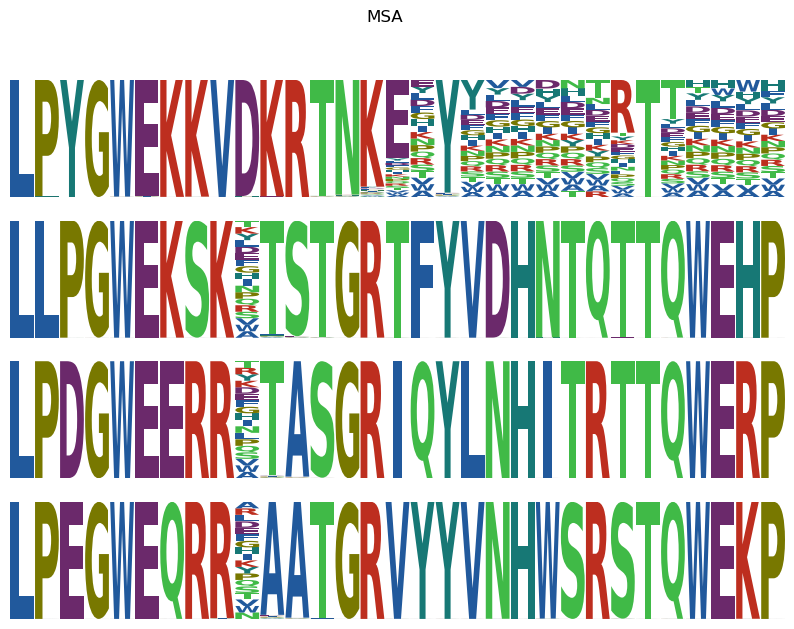

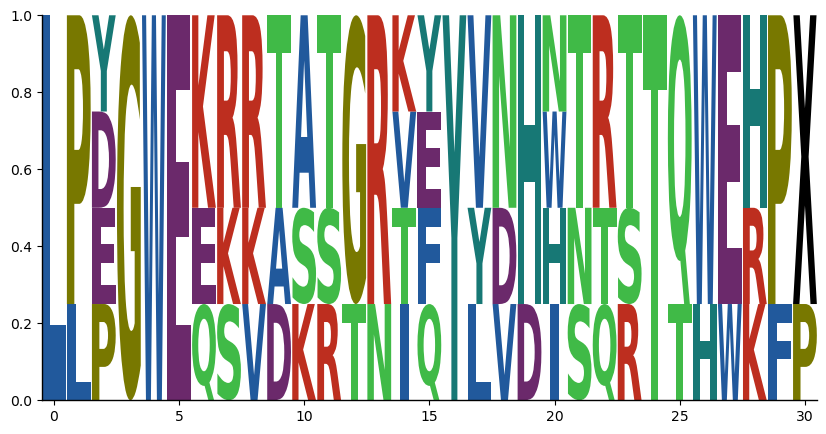

 ___    ___    ___    _____  _   _  ___   _____  ___    _   _  ___   _____  _ 
|  _`\ (  _`\ (  _`\ (  _  )( ) ( )(  _`\(_   _)|  _`\ ( ) ( )(  _`\(_   _)(_)
| (_) )| (_(_)| ( (_)| ( ) || `\| || (_(_) | |  | (_) )| | | || ( (_) | |  | |
| ,  / |  _)_ | |  _ | | | || , ` |`\__ \  | |  | ,  / | | | || |  _  | |  | |
| |\ \ | (_( )| (_( )| (_) || |`\ |( )_) | | |  | |\ \ | (_) || (_( ) | |  | |
(_) (_)(____/'(____/'(_____)(_) (_)`\____) (_)  (_) (_)(_____)(____/' (_)  (_)
                                                                              
                                                                              
 _____  _   _ 
(  _  )( ) ( )
| ( ) || `\| |
| | | || , ` |
| (_) || |`\ |
(_____)(_) (_)
              
              



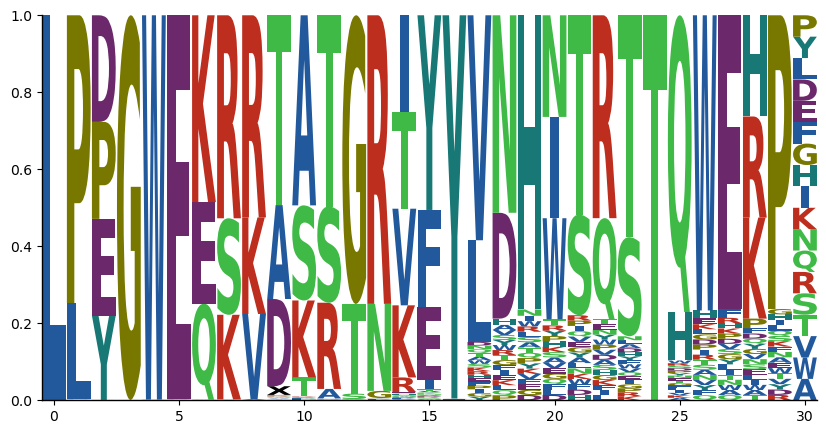

 _____  _      _  ___    _   _         ___    _   _  _____ 
(  _  )( )    (_)(  _`\ ( ) ( )/'\_/`\(  _`\ ( ) ( )(_   _)
| (_) || |    | || ( (_)| `\| ||     || (_(_)| `\| |  | |  
|  _  || |  _ | || |___ | , ` || (_) ||  _)_ | , ` |  | |  
| | | || |_( )| || (_, )| |`\ || | | || (_( )| |`\ |  | |  
(_) (_)(____/'(_)(____/'(_) (_)(_) (_)(____/'(_) (_)  (_)  
                                                           
                                                           



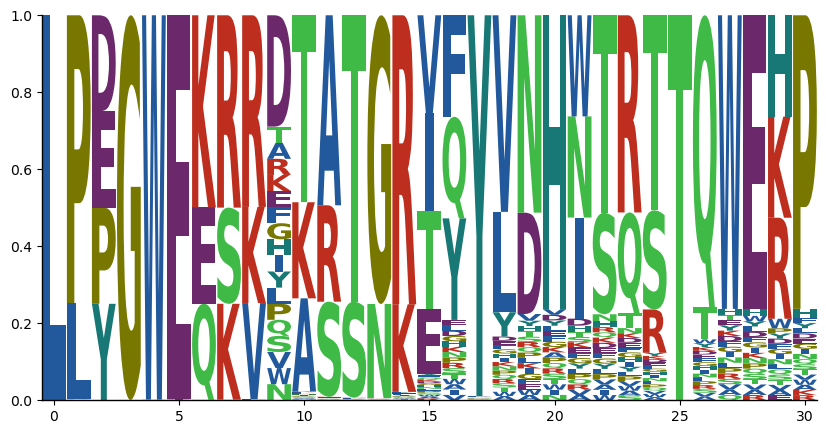

In [9]:
model.eval()
recon_data_train = model(dataset_msa.prot_space, deepseq)


print('Done')

from pyfiglet import Figlet
f = Figlet(font='puffy' ) #slant

print(recon_data_train[5])
alignment = recon_data_train[5]


plot_msa_from_preds(alignment, alphabets, figsize=(10,7), show_axis=False)



print(f.renderText('INPUT'))
plot_logos_probs(dataset_msa.prot_space, alphabets)

print(f.renderText('RECONSTRUCTION'))
plot_logos_probs(recon_data_train[0], alphabets)

print(f.renderText('ALIGNMENT'))
plot_logos_probs(recon_data_train[5], alphabets)



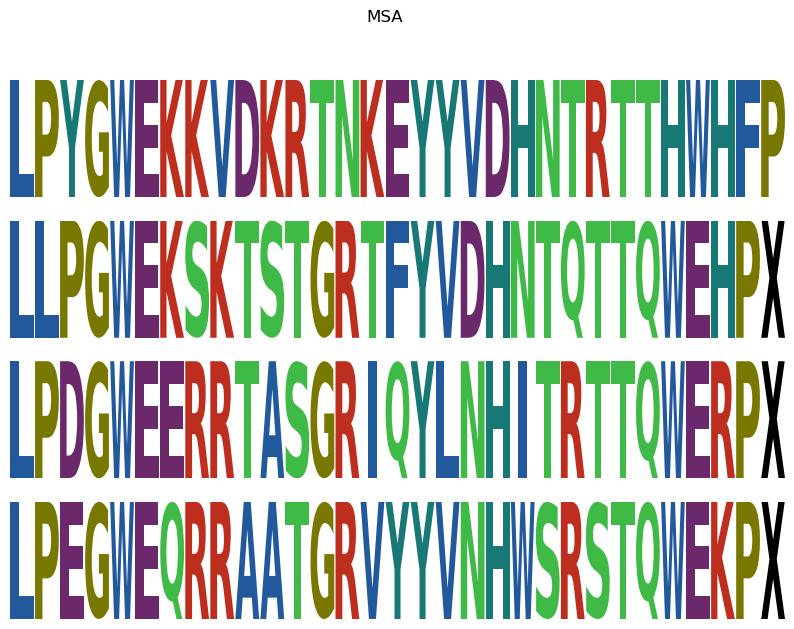

In [10]:
plot_msa_from_preds(trainloader.dataset.prot_space, alphabets, figsize=(10,7), show_axis=False)
